# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic recommender system (REC) dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [4]:
# import SCOPE-RL modules
import scope_rl
from recgym import RECEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.policy import SoftmaxHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler
from scope_rl.utils import MinMaxScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(scope_rl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [ ]:
# ignore warnings
import warnings
warnings.simplefilter('ignore')

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the recommender environment works.

#### RL setup for recommendation
In recommendation, the objective of the RL agent is to maximize reward.

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, the agent uses observation instead of state.
- `action`: Indicating which item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/rec/rec_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_customize_env.ipynb).

In [9]:
# standardized environment
env = gym.make("RECEnv-v0")

In [10]:
# for api compatibility to d3rlpy
from scope_rl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Recommender environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/rec/rec_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [13]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [12]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [13]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [14]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [14]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [15]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rec/rec_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_discrete_basic.ipynb).

In [16]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL as CQL
# transform offline dataset for d3rlpy
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
    episode_terminals=train_logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [17]:
# Use Conservative Q-Learning (CQL) policy
# base policy 1: hidden_units = [30, 30]
cql_b1 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [ ]:
cql_b1.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [19]:
# save model
cql_b1.save_model("d3rlpy_logs/cql_discrete_b1.pt")

In [20]:
# reload model
cql_b1.build_with_env(env)
cql_b1.load_model("d3rlpy_logs/cql_discrete_b1.pt")

2023-06-15 08:52:58 [warning  ] Parameters will be reinitialized.


In [21]:
# Use Conservative Q-Learning (CQL) policy
# base policy 2: hidden_units = [100]
cql_b2 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [ ]:
cql_b2.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [23]:
# save model
cql_b2.save_model("d3rlpy_logs/cql_discrete_b2.pt")

In [24]:
# reload model
cql_b2.build_with_env(env)
cql_b2.load_model("d3rlpy_logs/cql_discrete_b2.pt")

2023-06-15 08:53:09 [warning  ] Parameters will be reinitialized.


In [25]:
# Use Conservative Q-Learning (CQL) policy
# base policy 3: hidden_units = [50, 10]
cql_b3 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [ ]:
cql_b3.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [27]:
# save model
cql_b3.save_model("d3rlpy_logs/cql_discrete_b3.pt")

In [28]:
# reload model
cql_b3.build_with_env(env)
cql_b3.load_model("d3rlpy_logs/cql_discrete_b3.pt")

2023-06-15 08:53:22 [warning  ] Parameters will be reinitialized.


## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$


In [29]:
# import ope modules from SCOPE-RL
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR

In [30]:
# define evaluation policies (epsilon-greedy and softmax)
cql_b1_00 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon00", epsilon=0.0, random_state=random_state)
cql_b1_03 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon03", epsilon=0.3, random_state=random_state)
cql_b1_07 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon07", epsilon=0.7, random_state=random_state)
cql_b1_soft = SoftmaxHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_softmax", random_state=random_state)

cql_b2_00 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon00", epsilon=0.0, random_state=random_state)
cql_b2_03 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon03", epsilon=0.3, random_state=random_state)
cql_b2_07 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon07", epsilon=0.7, random_state=random_state)
cql_b2_soft = SoftmaxHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_softmax", random_state=random_state)

cql_b3_00 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon00", epsilon=0.0, random_state=random_state)
cql_b3_03 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon03", epsilon=0.3, random_state=random_state)
cql_b3_07 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon07", epsilon=0.7, random_state=random_state)
cql_b3_soft = SoftmaxHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_softmax", random_state=random_state)

evaluation_policies = [
    cql_b1_00, cql_b1_03, cql_b1_07, cql_b1_soft, 
    cql_b2_00, cql_b2_03, cql_b2_07, cql_b2_soft, 
    cql_b3_00, cql_b3_03, cql_b3_07, cql_b3_soft,
]

In [31]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [33]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [34]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [35]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [36]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict

{'cql_b1_epsilon00':            policy_value  relative_policy_value
 on_policy      2.157547               1.000000
 dm            22.760989              10.549476
 tis            0.689409               0.319534
 pdis           1.353646               0.627401
 dr            20.650004               9.571057
 sntis          1.833986               0.850033
 snpdis         1.738387               0.805724
 sndr          -3.673413              -1.702588,
 'cql_b1_epsilon03':            policy_value  relative_policy_value
 on_policy      1.246869               1.000000
 dm            29.565089              23.711471
 tis            0.585341               0.469449
 pdis           0.884818               0.709632
 dr            18.392495              14.750949
 sntis          0.835202               0.669840
 snpdis         1.074910               0.862087
 sndr          10.758133               8.628120,
 'cql_b1_epsilon07':            policy_value  relative_policy_value
 on_policy      0.074233  

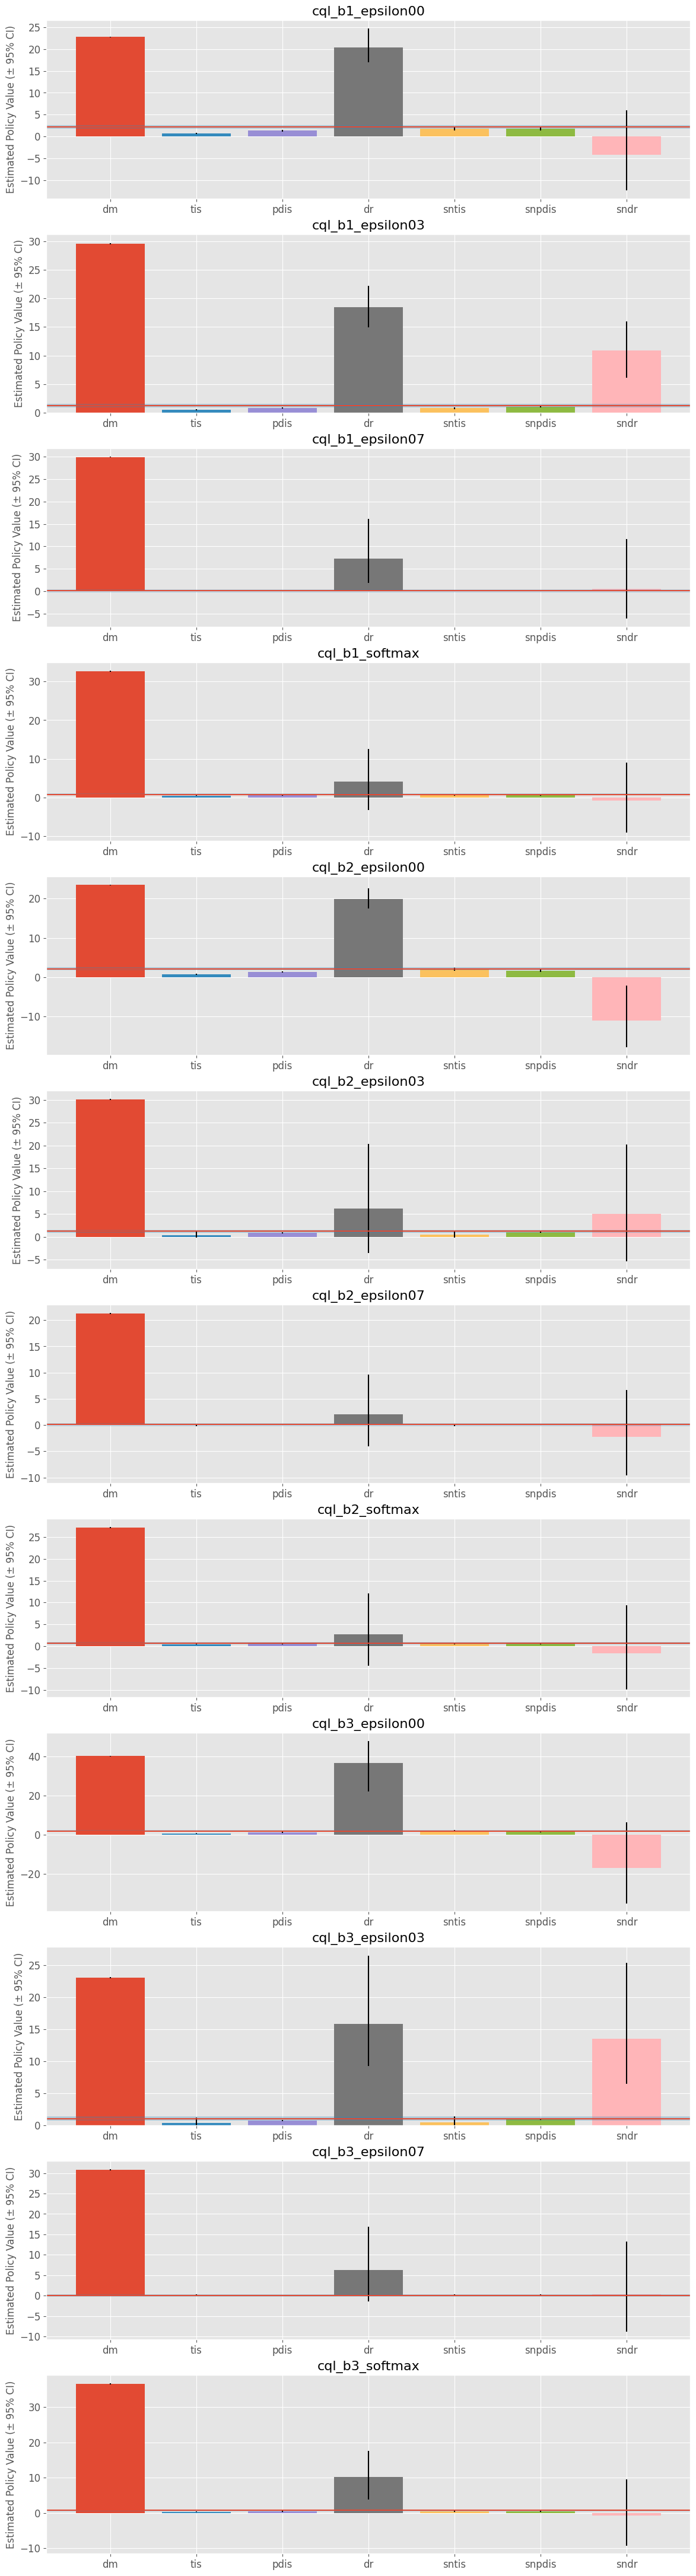

In [37]:
# visualize and compare the result
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

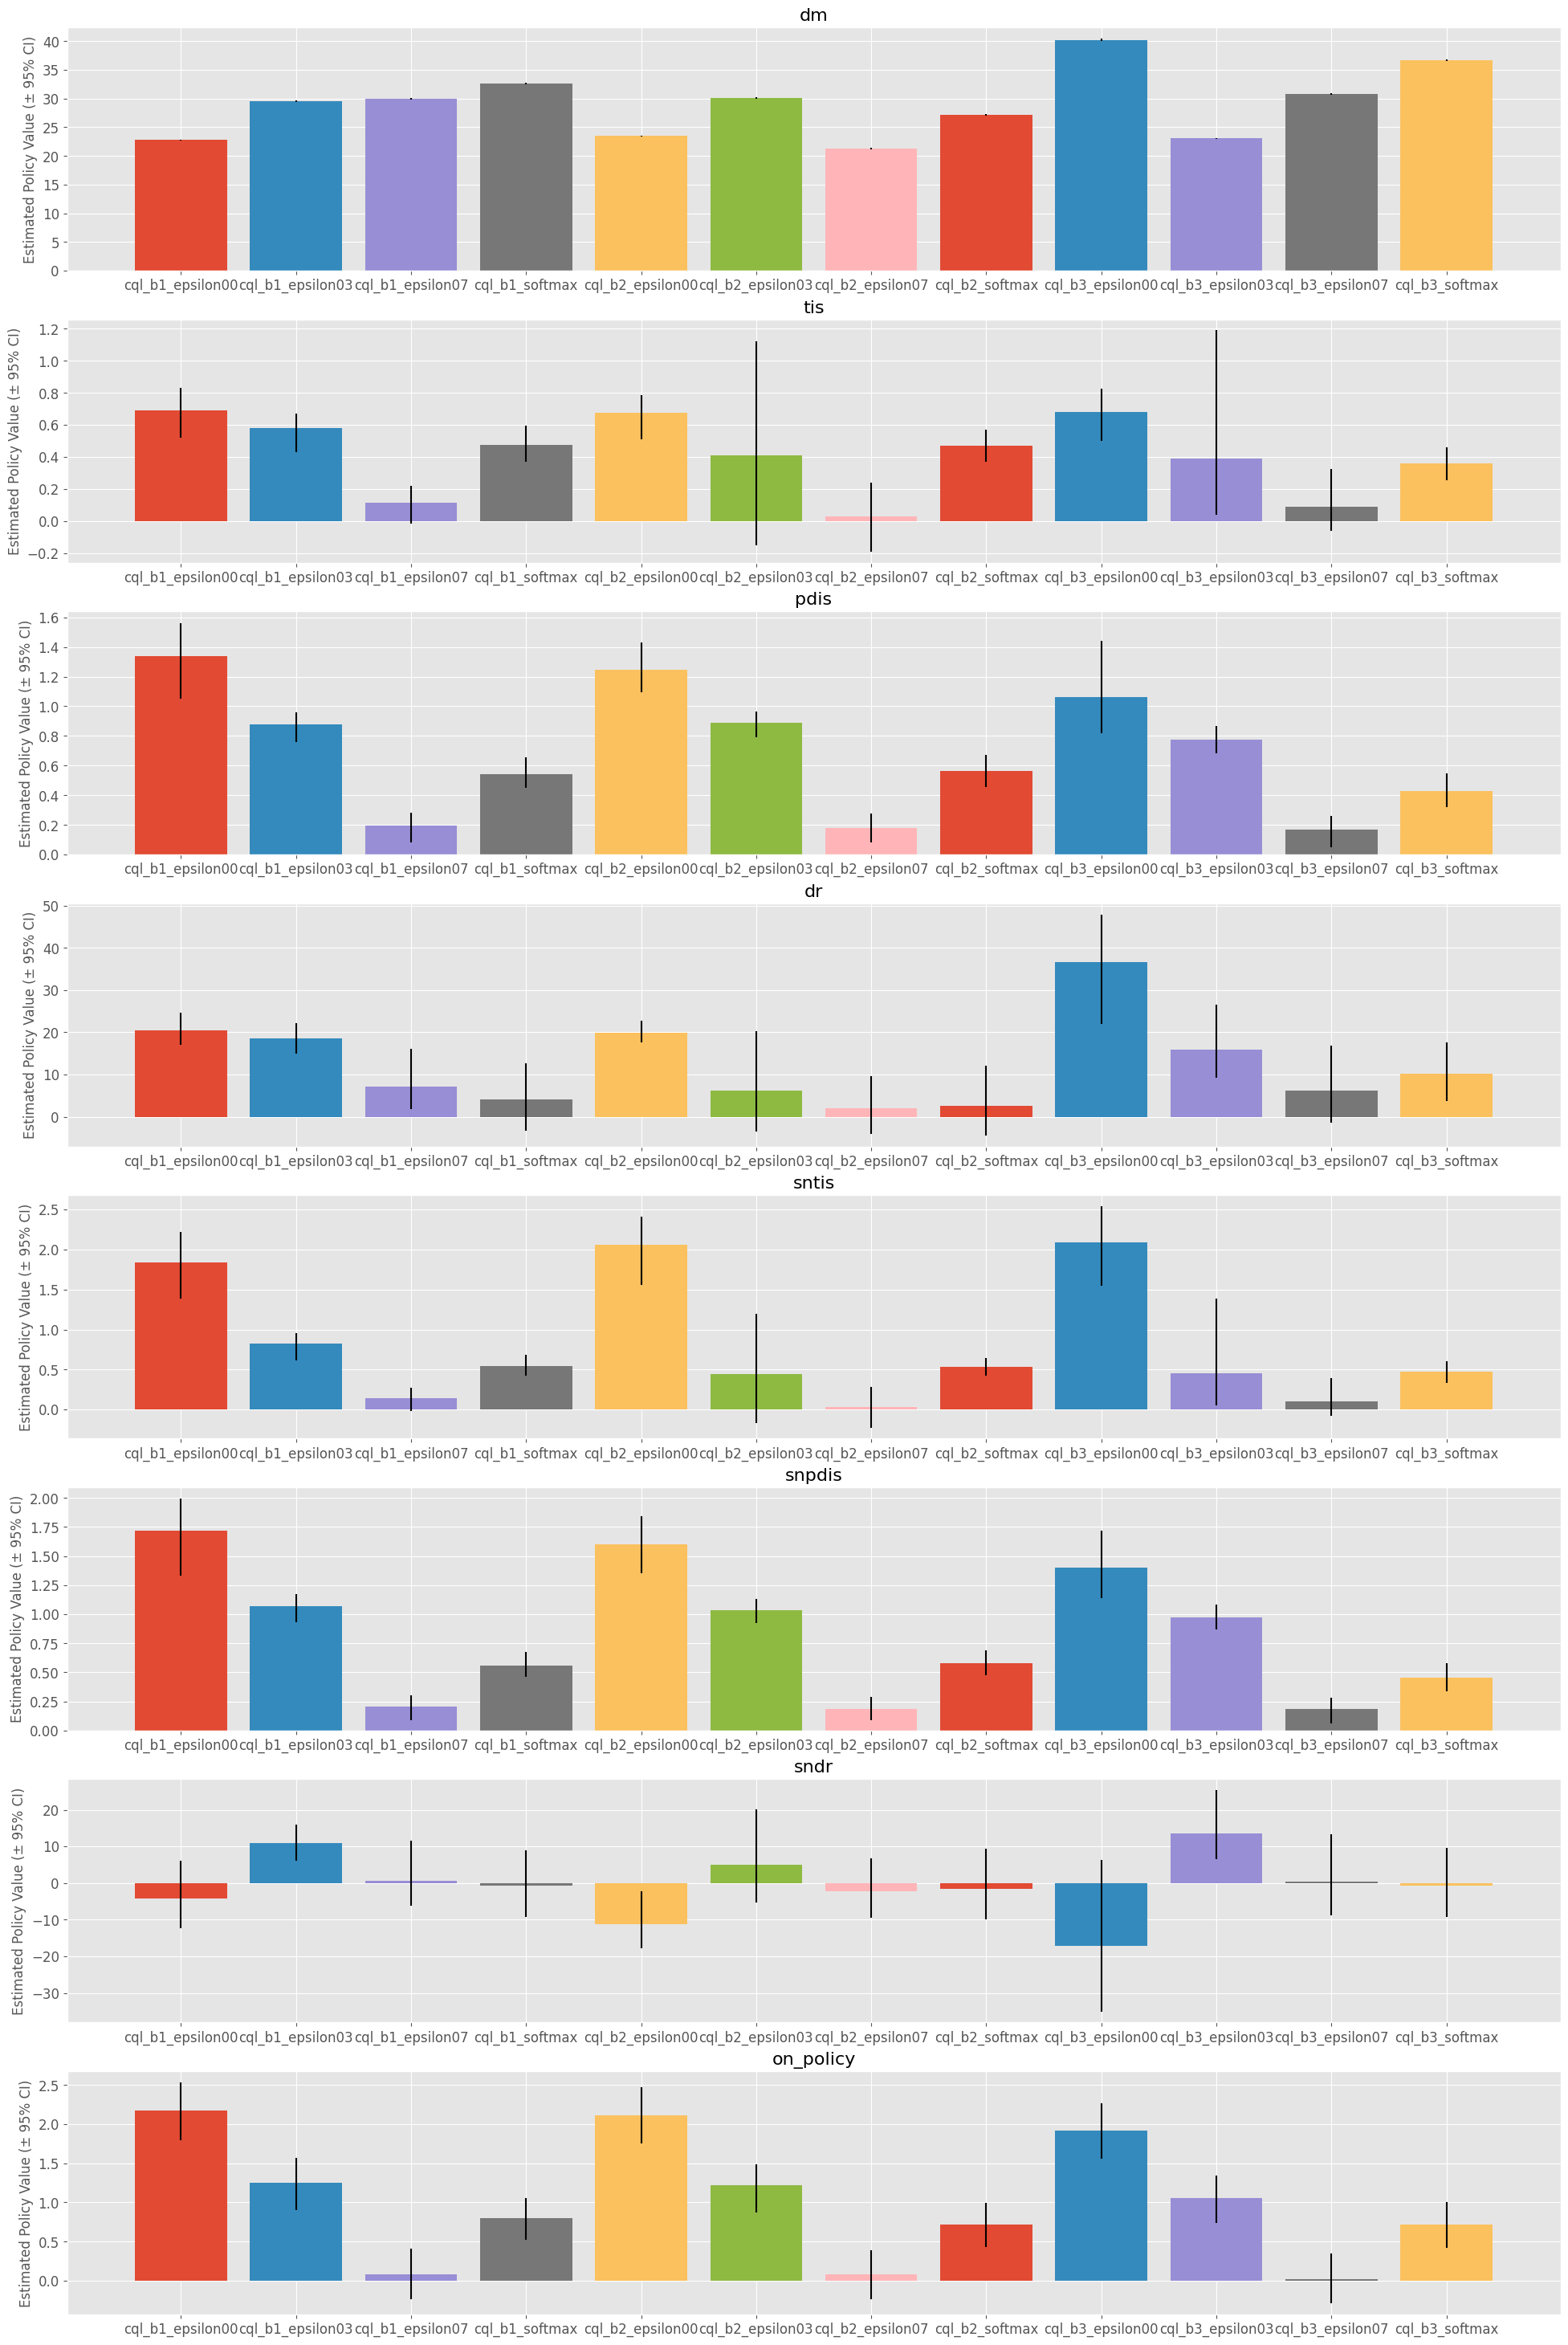

In [38]:
# we can also compare the policy value of candidate OPE estimators estimated by a single OPE estimator
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, hue="policy", sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, hue="policy", sharey=False)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [39]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope.discrete import CumulativeDistributionDM as CD_DM
from scope_rl.ope.discrete import CumulativeDistributionTIS as CD_IS
from scope_rl.ope.discrete import CumulativeDistributionTDR as CD_DR
from scope_rl.ope.discrete import CumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope.discrete import CumulativeDistributionSNTDR as CD_SNDR

In [40]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

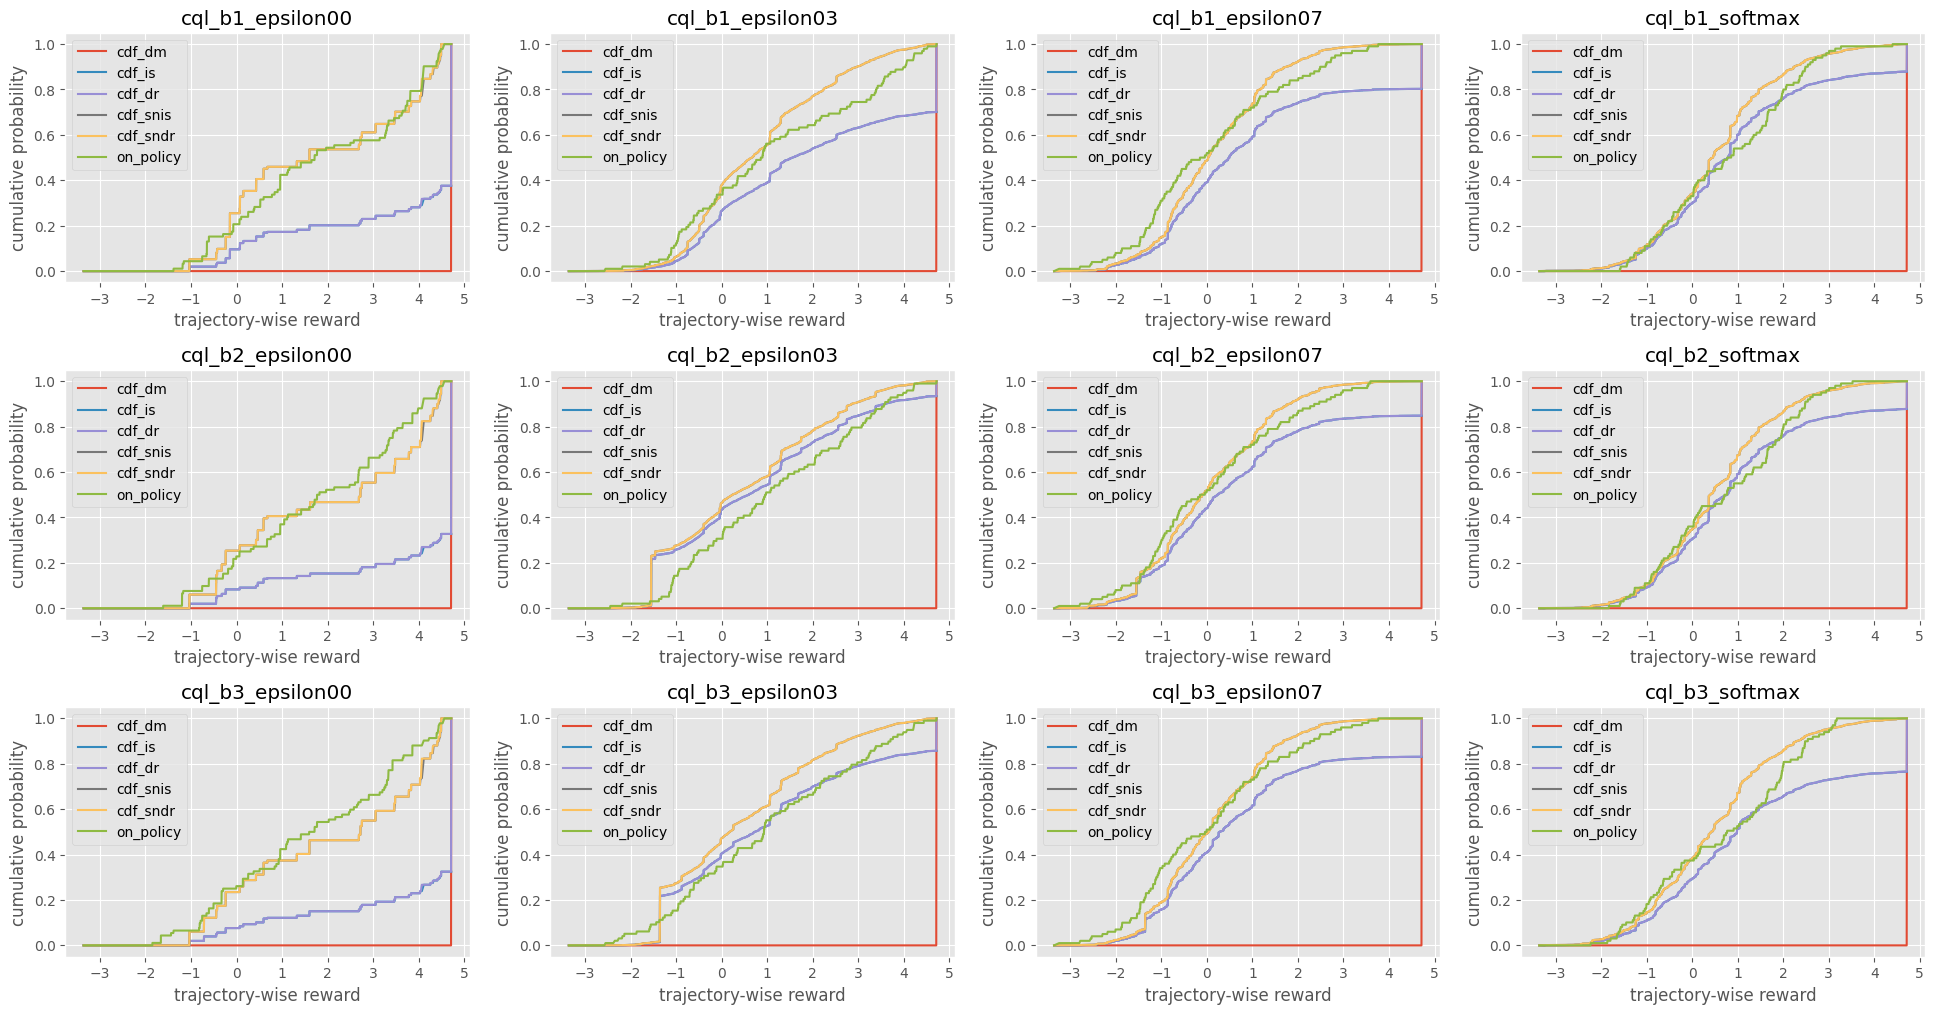

In [41]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function(input_dict, n_cols=4)

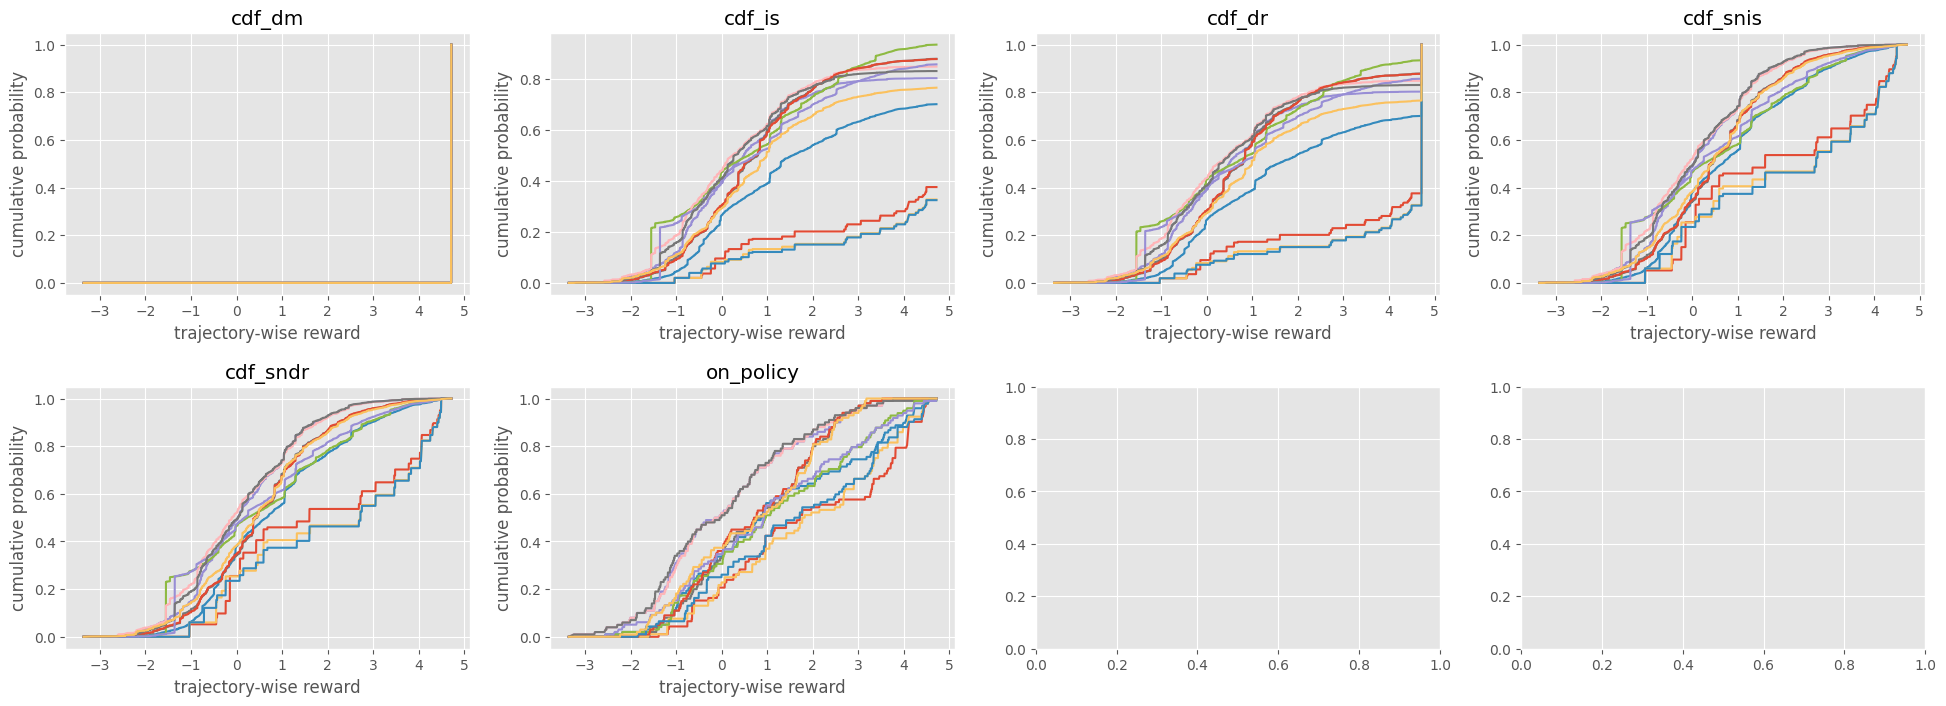

In [42]:
# cumulative distribution function comparison by each OPE estimator
# legend (evaluation policy name) is omitted here
cd_ope.visualize_cumulative_distribution_function(
    input_dict, 
    hue="policy",
    n_cols=4,
    legend=False,
)

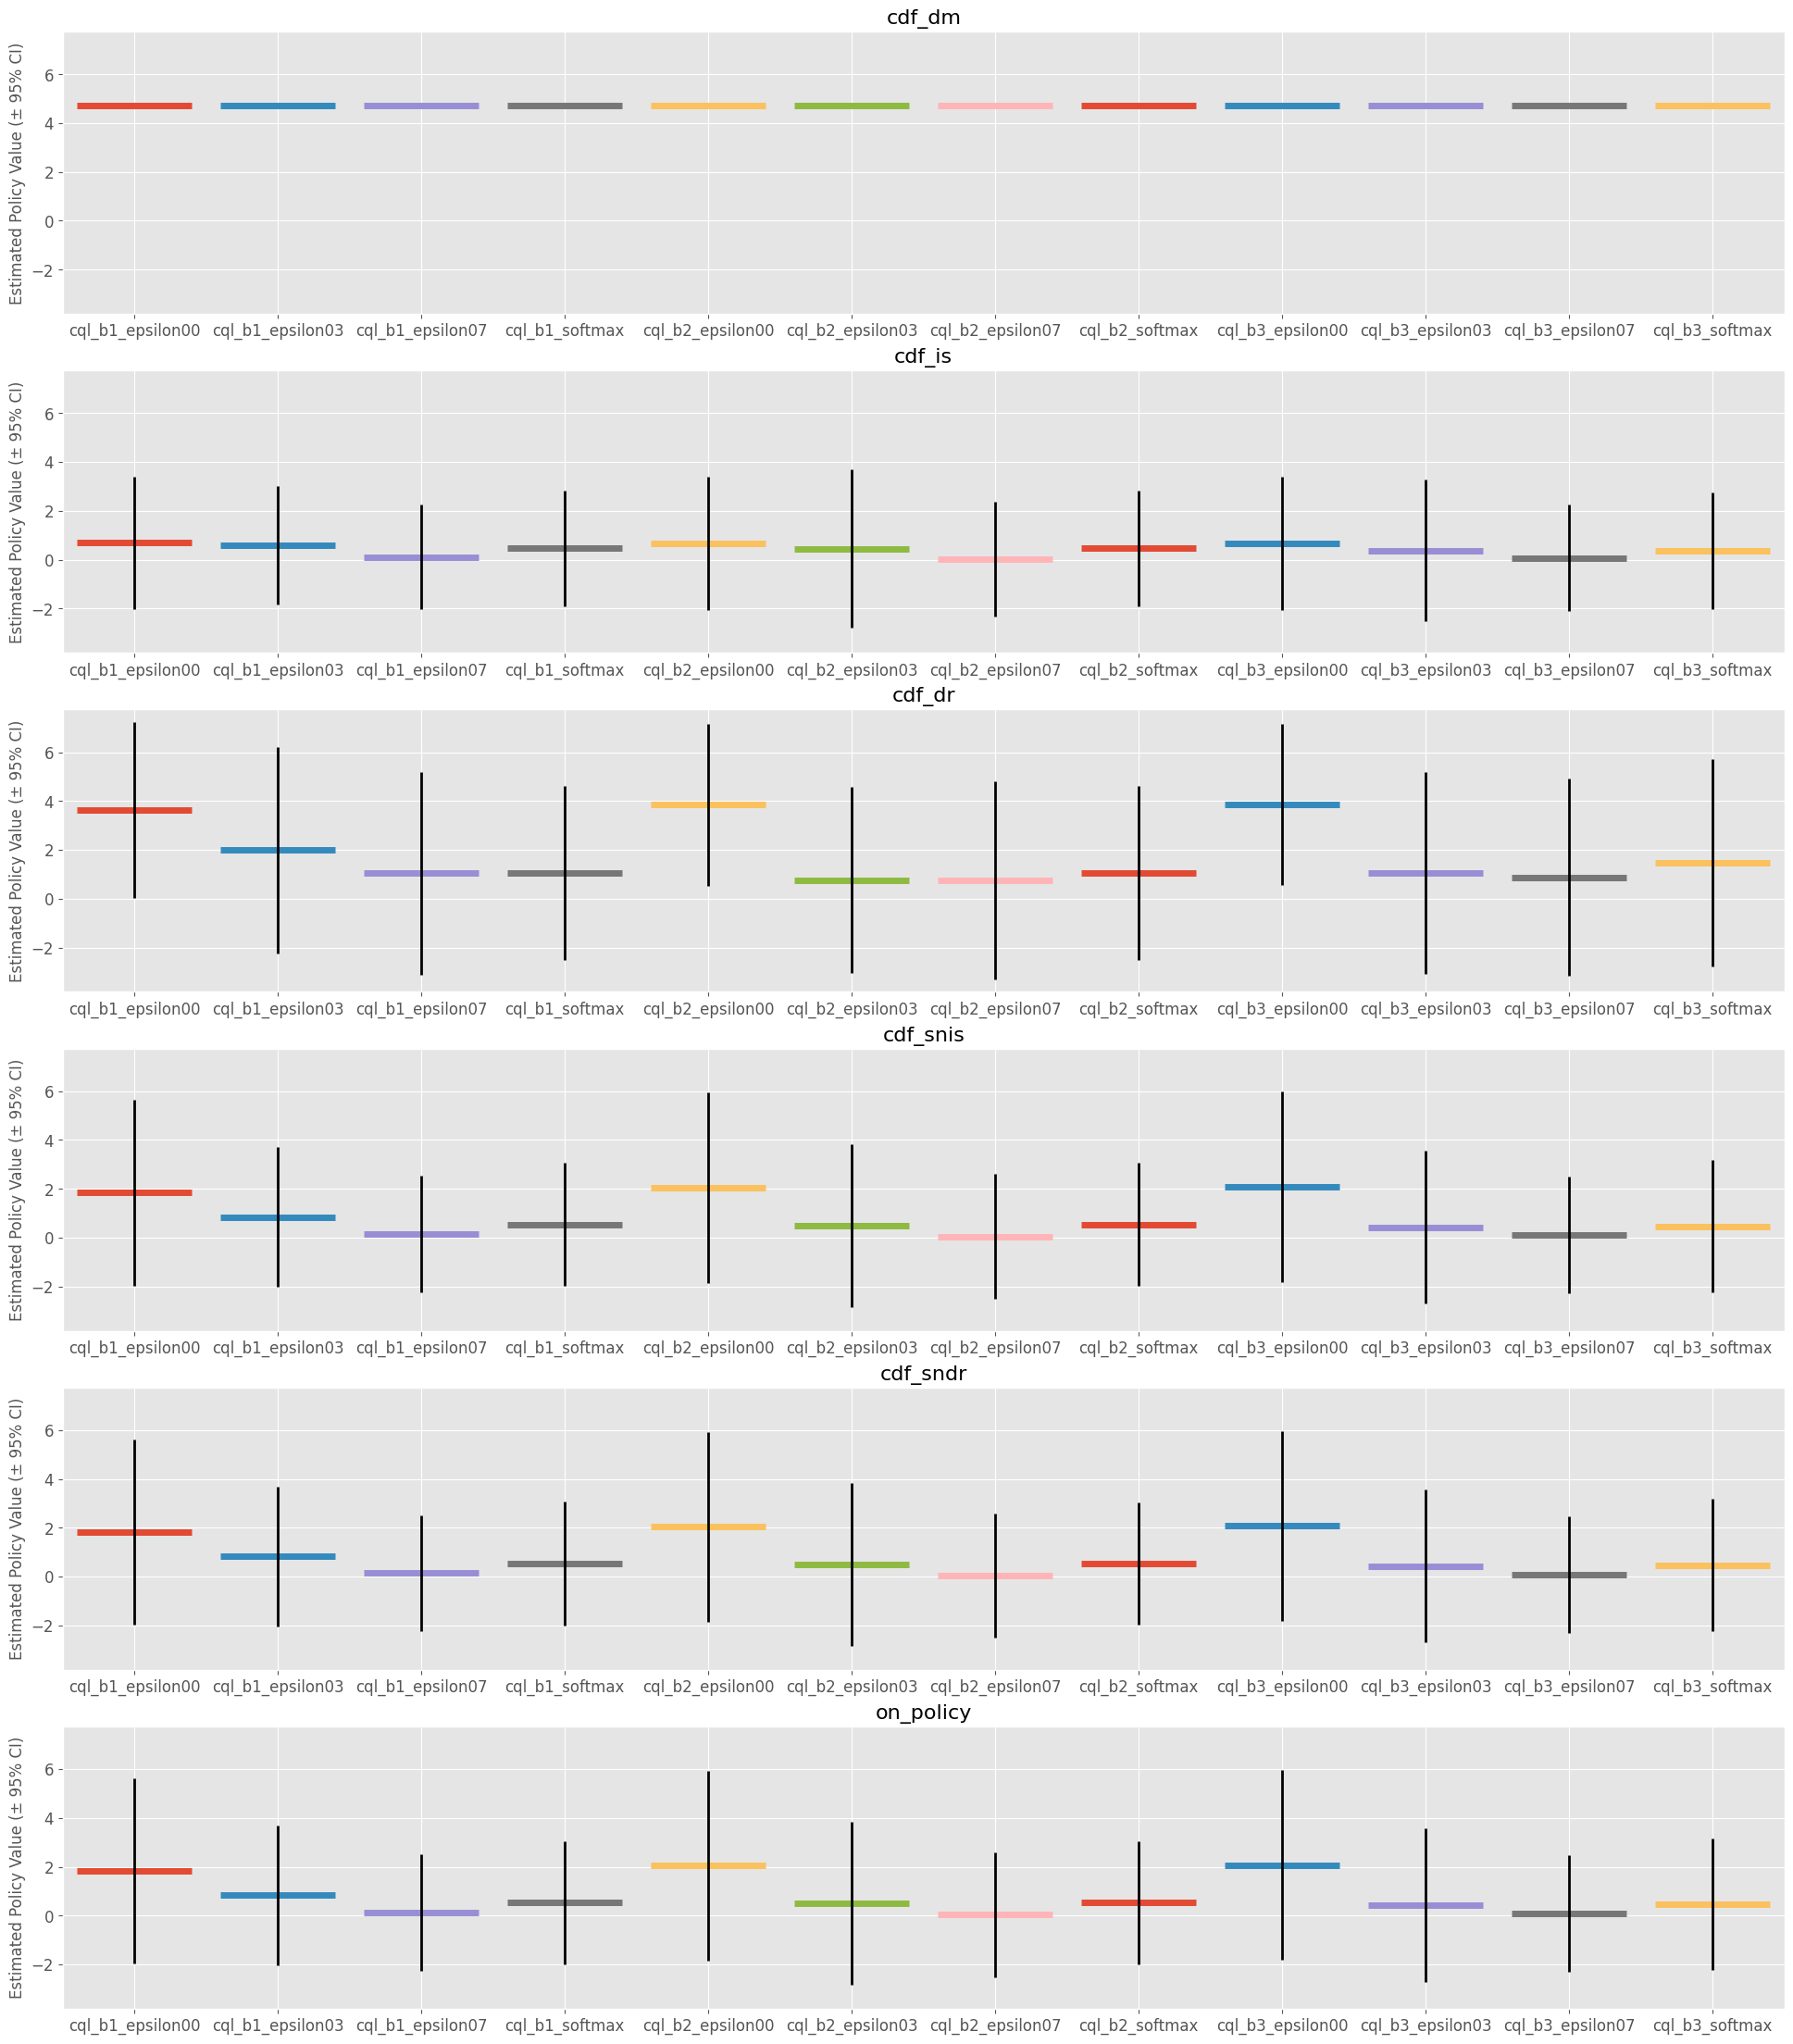

In [43]:
# policy value calculated from cumulative distribution function
mean_dict = cd_ope.estimate_mean(input_dict)
variance_dict = cd_ope.estimate_variance(input_dict)

# visualize the policy value and its confidence intervals based on the mean and variance
# cd_ope.visualize_policy_value(input_dict, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_policy_value(input_dict, hue="policy", sharey=True)

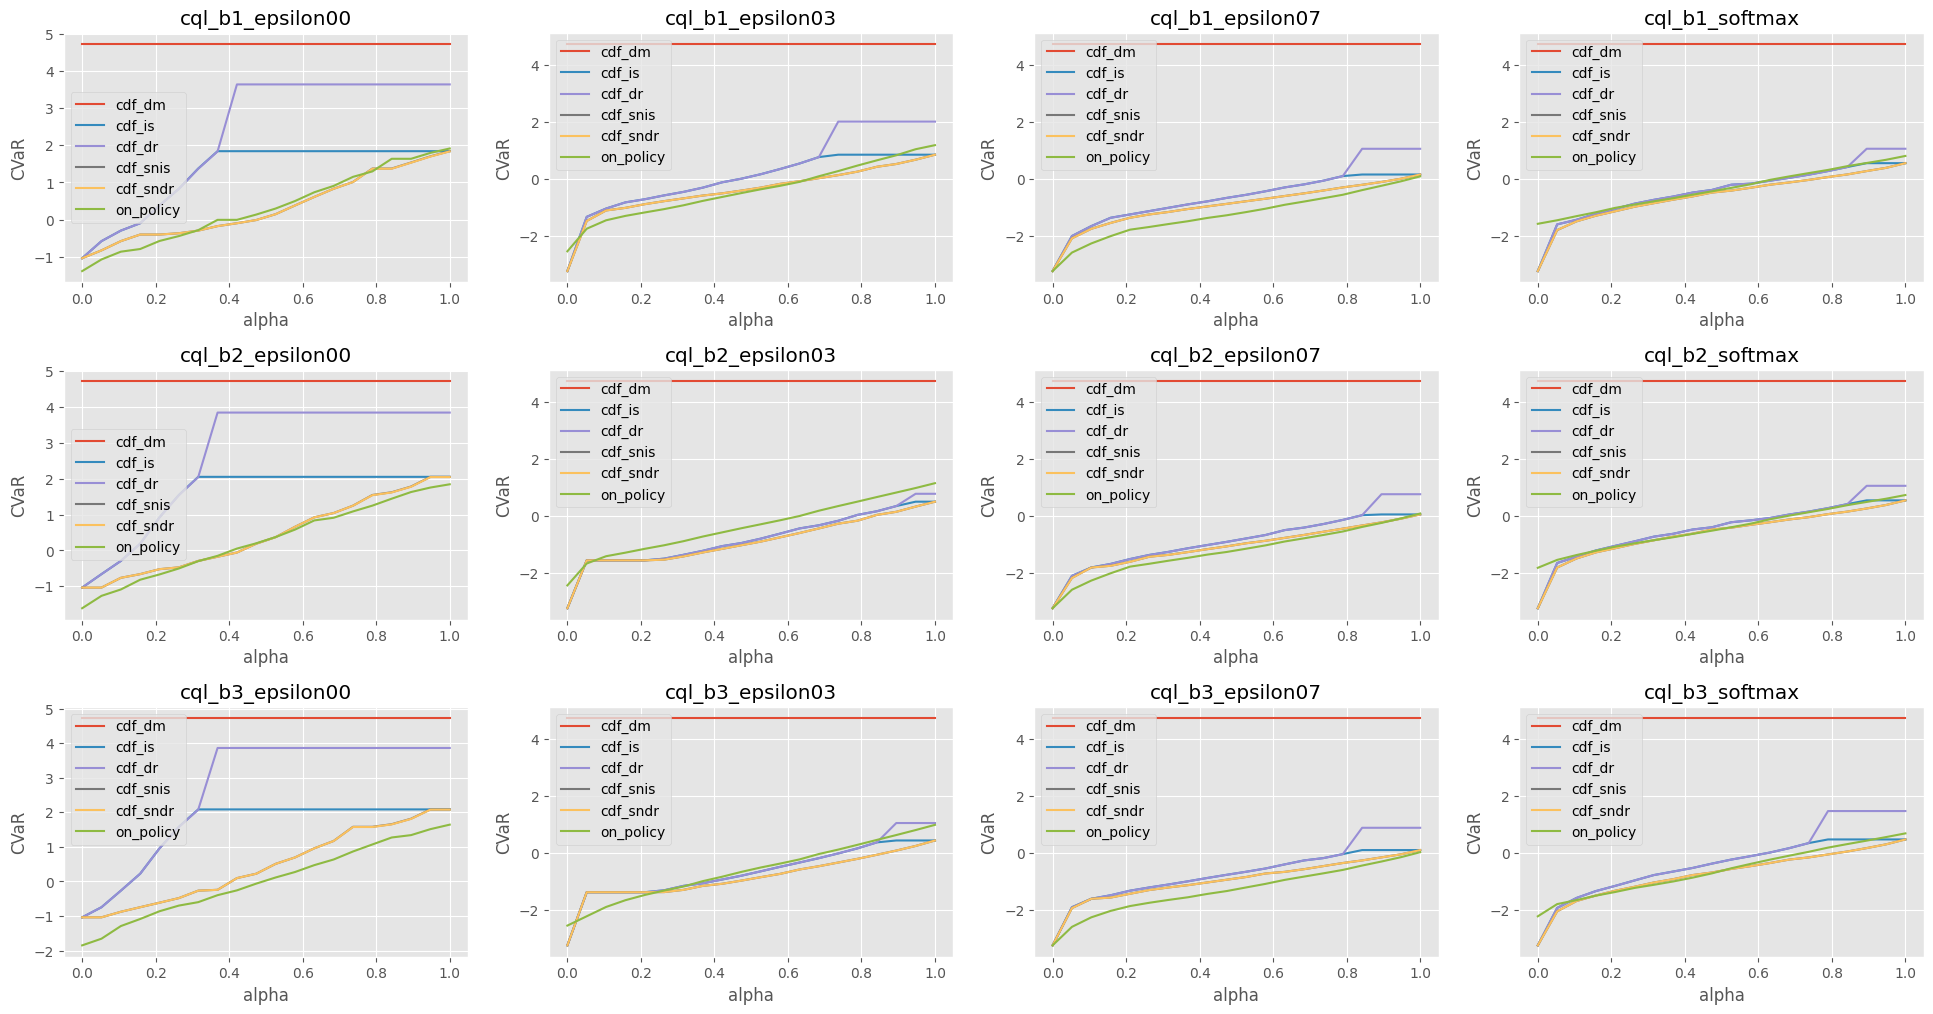

In [44]:
# conditional value at risk
cvar_dict = cd_ope.estimate_conditional_value_at_risk(input_dict, alphas=0.3)
# visualize conditional value at risk
cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)

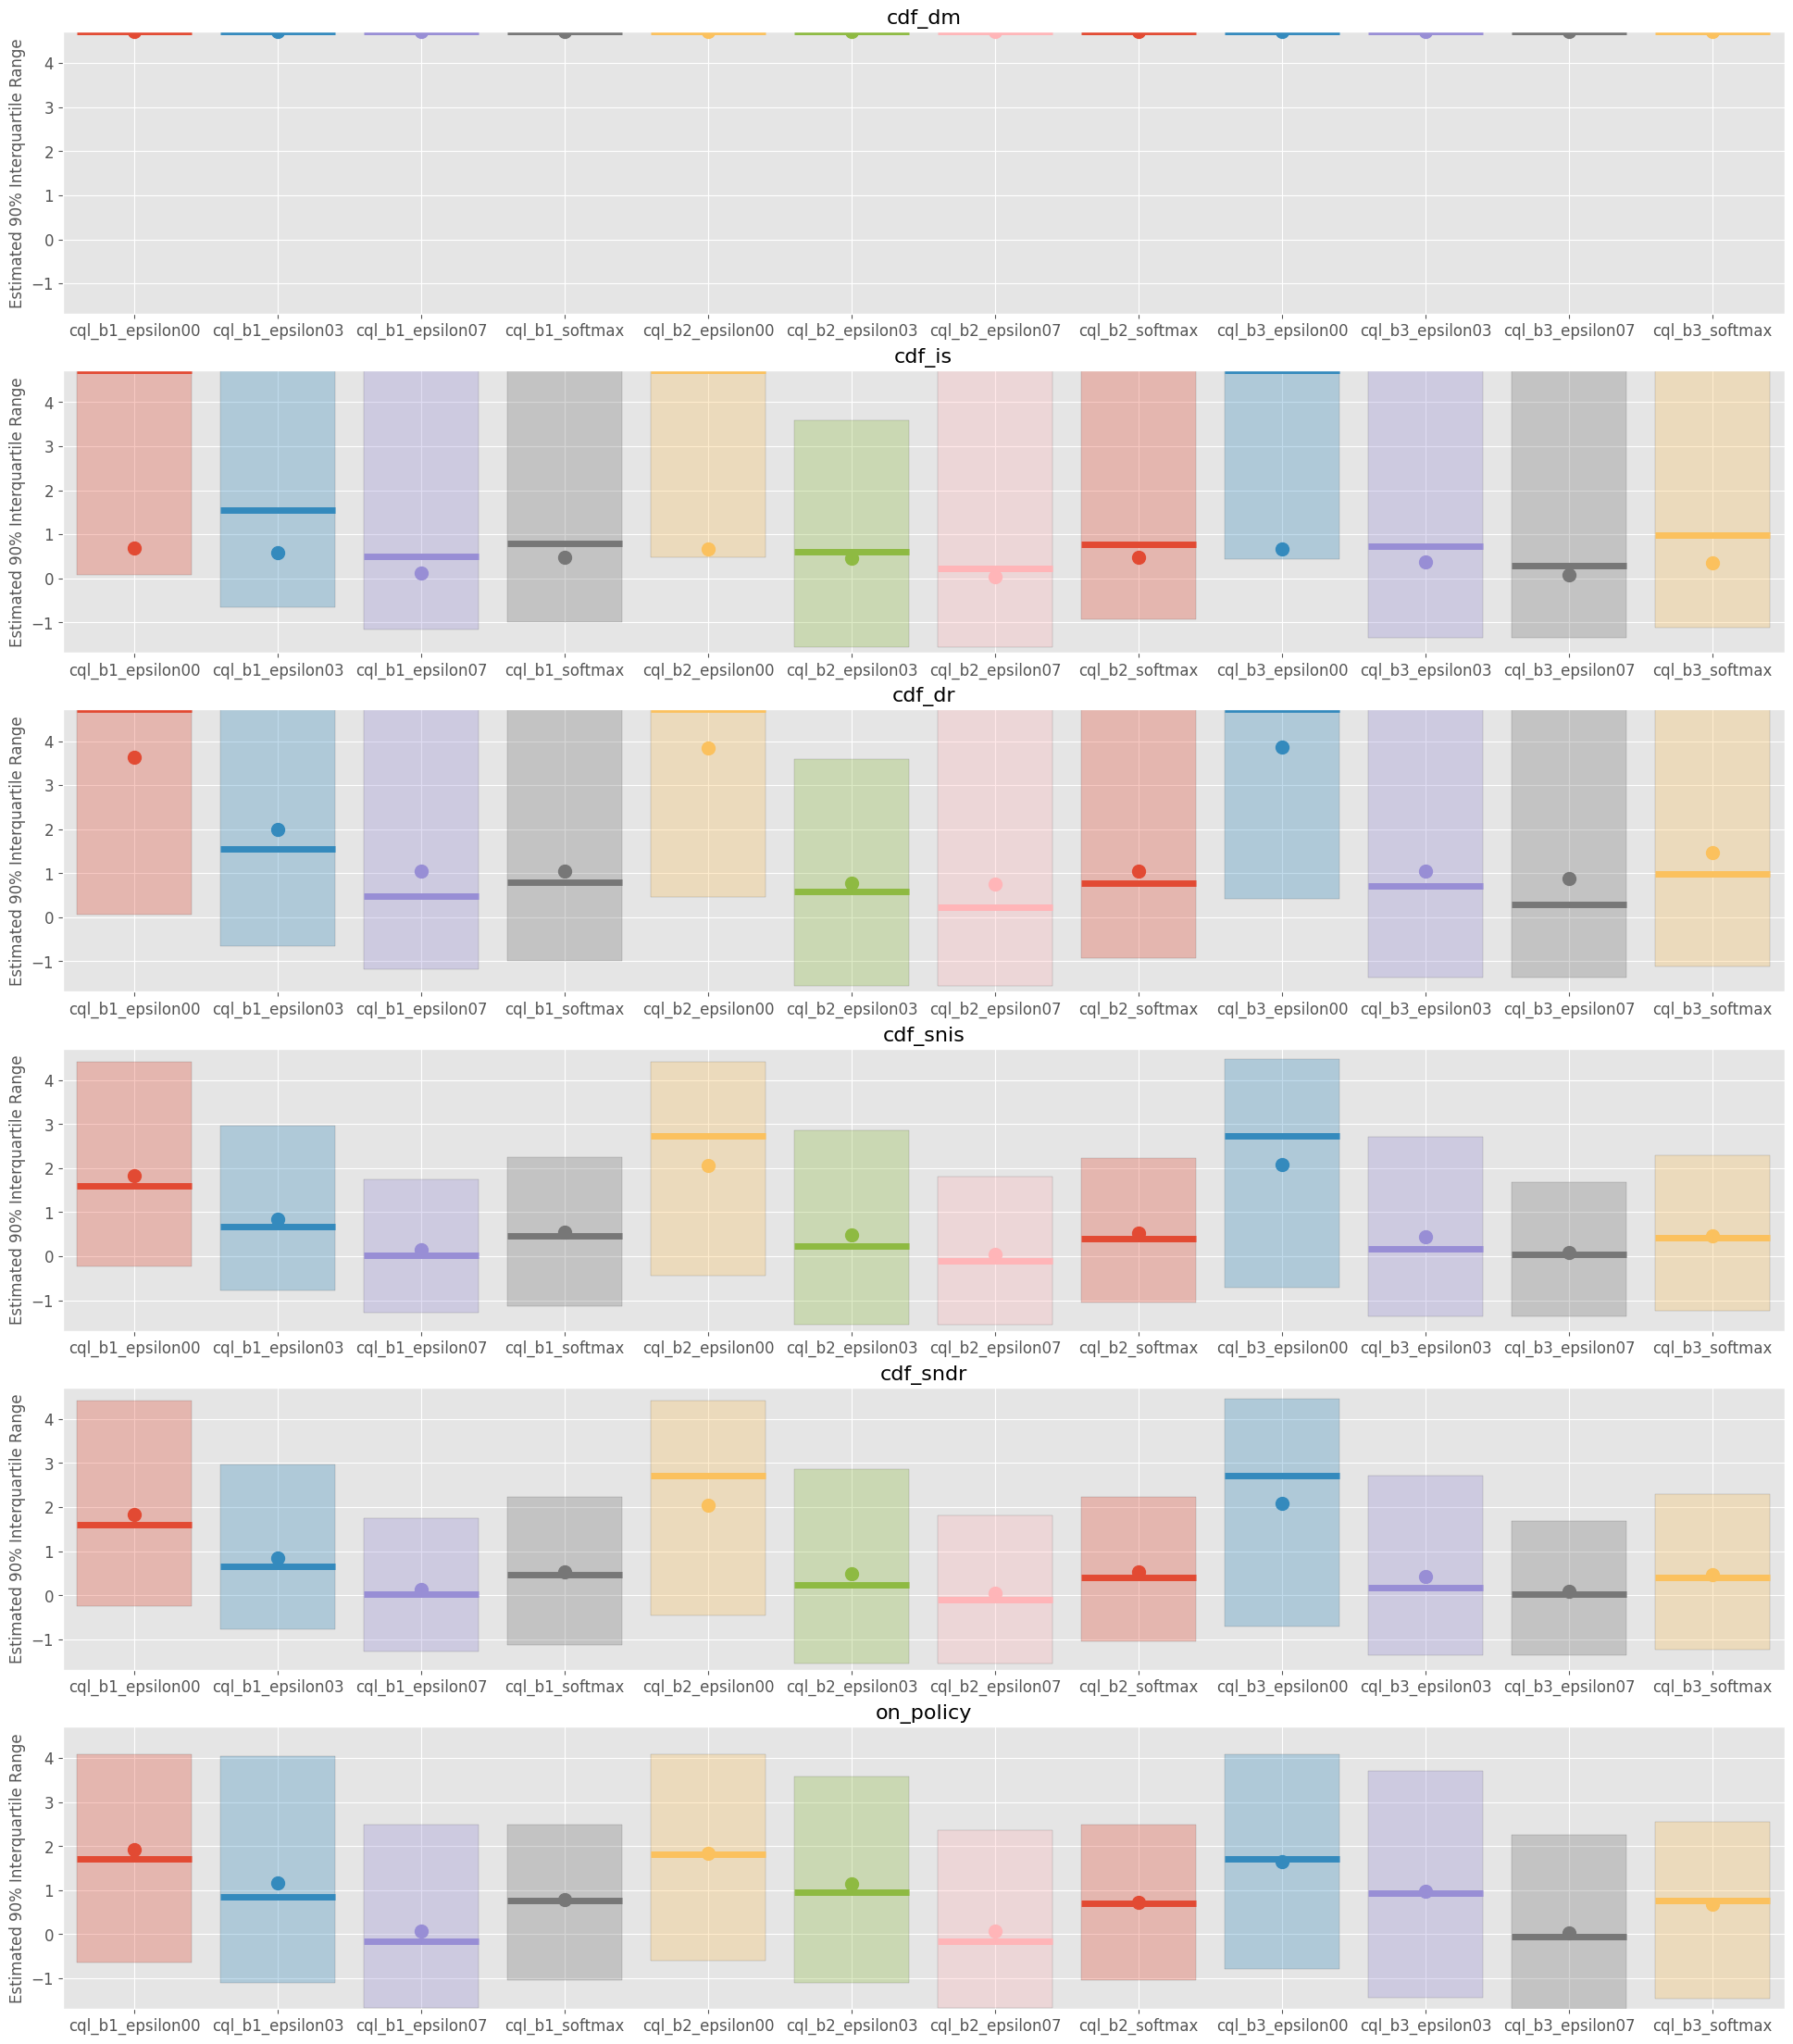

In [45]:
# interquartile range
interquartile_range_dict = cd_ope.estimate_interquartile_range(input_dict, alpha=0.10)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, hue="policy", sharey=True)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [46]:
from scope_rl.ope import OffPolicySelection

In [47]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [48]:
ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)

ranking  policy_value  relative_policy_value  variance  \
0   cql_b1_epsilon00      2.157547               3.214537  4.021215   
1   cql_b2_epsilon00      2.096161               3.123078  3.733093   
2   cql_b3_epsilon00      1.912300               2.849142  4.164964   
3   cql_b1_epsilon03      1.246869               1.857714  3.924015   
4   cql_b2_epsilon03      1.216732               1.812814  3.418337   
5   cql_b3_epsilon03      1.059660               1.578792  3.850565   
6     cql_b1_softmax      0.791618               1.179435  1.904350   
7     cql_b3_softmax      0.725242               1.080541  2.465290   
8     cql_b2_softmax      0.723283               1.077622  1.896150   
9   cql_b1_epsilon07      0.074233               0.110600  2.578644   
10  cql_b2_epsilon07      0.073426               0.109398  2.511811   
11  cql_b3_epsilon07      0.019941               0.029710  2.500521   

   ranking_by_lower_quartile  lower_quartile  \
0           cql_b1_epsilon00       -0.755434   
1           cql_b1_epsilon03       -1.167652   
2           cql_b1_epsilon07       -1.195790   
3             cql_b1_softmax       -1.198008   
4           cql_b2_epsilon00       -1.366235   
5           cql_b2_epsilon03       -1.368732   
6           cql_b2_epsilon07       -1.388881   
7             cql_b2_softmax       -1.618623   
8           cql_b3_epsilon00       -1.889978   
9           cql_b3_epsilon03       -2.193077   
10          cql_b3_epsilon07       -2.193077   
11            cql_b3_softmax       -2.193077   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                      cql_b1_epsilon00                  -1.134634  
1                      cql_b2_epsilon00                  -1.280934  
2                        cql_b1_softmax                  -1.485017  
3                        cql_b2_softmax                  -1.590460  
4                      cql_b3_epsilon00                  -1.655192  
5                      cql_b2_epsilon03                  -1.784863  
6                        cql_b3_softmax                  -1.840162  
7                      cql_b1_epsilon03                  -1.880217  
8                      cql_b3_epsilon03                  -2.309768  
9                      cql_b3_epsilon07                  -2.700990  
10                     cql_b2_epsilon07                  -2.700990  
11                     cql_b1_epsilon07                  -2.700990

In [49]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [50]:
ranking_df

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0   cql_b3_epsilon00               40.222854                        59.928183   
 1     cql_b3_softmax               36.658041                        54.616954   
 2     cql_b1_softmax               32.684865                        48.697304   
 3   cql_b3_epsilon07               30.820609                        45.919742   
 4   cql_b2_epsilon03               30.089633                        44.830657   
 5   cql_b1_epsilon07               29.961315                        44.639477   
 6   cql_b1_epsilon03               29.565089                        44.049138   
 7     cql_b2_softmax               27.157176                        40.461579   
 8   cql_b2_epsilon00               23.485870                        34.991686   
 9   cql_b3_epsilon03               23.042747                        34.331476   
 10  cql_b1_epsilon00               22.760989                        33.911683   
 11  cql_b

In [51]:
metric_df

estimator  mean_squared_error  rank_correlation        pvalue  regret@1  \
0        dm          813.982774         -0.090909  7.787254e-01  0.245247   
1       tis            0.626721          0.909091  4.191045e-05  0.000000   
2      pdis            0.217911          0.972028  1.286812e-07  0.000000   
3        dr          216.128231          0.853147  4.181179e-04  0.245247   
4     sntis            0.116957          0.874126  2.007131e-04  0.245247   
5    snpdis            0.079796          0.979021  3.089801e-08  0.000000   
6      sndr           70.140378         -0.286713  3.662515e-01  1.097887   

   type_i_error_rate  type_ii_error_rate  
0           0.000000                 0.0  
1           0.000000                 0.0  
2           0.000000                 0.0  
3           0.000000                 0.0  
4           0.000000                 0.0  
5           0.000000                 0.0  
6           0.583333                 0.0

In [52]:
ranking_df, metric_df = ops.select_by_policy_value_via_cumulative_distribution_ope(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [53]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0    cdf_dm           14.291447         -1.000000  0.000000  2.137606   
1    cdf_is            0.624925          0.909091  0.000042  0.000000   
2    cdf_dr            1.053926          0.748252  0.005124  0.245247   
3  cdf_snis            0.116423          0.874126  0.000201  0.245247   
4  cdf_sndr            0.116915          0.874126  0.000201  0.245247   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [54]:
ranking_df, metric_df = ops.select_by_policy_value_lower_bound(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    return_metrics=True,
    return_by_dataframe=True,
    random_state=12345,
)

In [55]:
metric_df

ci estimator  mean_squared_error  rank_correlation        pvalue  \
0   bootstrap        dm                 NaN         -0.090909  7.787254e-01   
1   bootstrap       tis                 NaN          0.629371  2.831967e-02   
2   bootstrap      pdis                 NaN          0.951049  2.038425e-06   
3   bootstrap        dr                 NaN          0.664336  1.845272e-02   
4   bootstrap     sntis                 NaN          0.615385  3.316990e-02   
5   bootstrap    snpdis                 NaN          0.972028  1.286812e-07   
6   bootstrap      sndr                 NaN         -0.174825  5.868237e-01   
7   bernstein        dm                 NaN         -0.090909  7.787254e-01   
8   bernstein       tis                 NaN          0.622378  3.067590e-02   
9   bernstein      pdis                 NaN          0.573427  5.126559e-02   
10  bernstein        dr                 NaN          0.272727  3.910968e-01   
11  bernstein     sntis                 NaN          0.608392  3.580600e-02   
12  bernstein    snpdis                 NaN          0.664336  1.845272e-02   
13  bernstein      sndr                 NaN         -0.377622  2.262060e-01   
14  hoeffding        dm                 NaN          0.034965  9.140933e-01   
15  hoeffding       tis                 NaN         -0.293706  3.541476e-01   
16  hoeffding      pdis                 NaN         -0.307692  3.305893e-01   
17  hoeffding        dr                 NaN         -0.384615  2.170202e-01   
18  hoeffding     sntis                 NaN         -0.517483  8.486877e-02   
19  hoeffding    snpdis                 NaN         -0.363636  2.452650e-01   
20  hoeffding      sndr                 NaN         -0.468531  1.244548e-01   
21      ttest        dm                 NaN         -0.090909  7.787254e-01   
22      ttest       tis                 NaN          0.713287  9.201780e-03   
23      ttest      pdis                 NaN          0.972028  1.286812e-07   
24      ttest        dr                 NaN          0.664336  1.845272e-02   
25      ttest     sntis                 NaN          0.741259  5.801150e-03   
26      ttest    snpdis                 NaN          0.979021  3.089801e-08   
27      ttest      sndr                 NaN         -0.265734  4.038331e-01   

    regret@1  type_i_error_rate  type_ii_error_rate  
0   0.245247           0.000000                 0.0  
1   0.061386           0.333333                 0.0  
2   0.000000           0.000000                 0.0  
3   0.245247           0.500000                 0.0  
4   0.061386           0.333333                 0.0  
5   0.000000           0.000000                 0.0  
6   0.910678           0.833333                 0.0  
7   0.245247           0.000000                 0.0  
8   0.061386           0.500000                 0.0  
9   0.910678           0.333333                 0.0  
10  0.061386           0.750000                 0.0  
11  0.061386           0.500000                 0.0  
12  0.910678           0.250000                 0.0  
13  0.910678           1.000000                 0.0  
14  2.084120           1.000000                 0.0  
15  0.061386           1.000000                 0.0  
16  0.940814           1.000000                 0.0  
17  2.084120           1.000000                 0.0  
18  0.061386           1.000000                 0.0  
19  2.084120           1.000000                 0.0  
20  2.084120           1.000000                 0.0  
21  0.245247           0.000000                 0.0  
22  0.000000           0.333333                 0.0  
23  0.000000           0.000000                 0.0  
24  0.245247           0.416667                 0.0  
25  0.061386           0.333333                 0.0  
26  0.000000           0.000000                 0.0  
27  0.910678           0.833333                 0.0

In [56]:
ranking_df, metric_df = ops.select_by_lower_quartile(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [57]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret  \
0    cdf_dm           39.417032         -1.000000  0.000000     NaN   
1    cdf_is            0.440326          0.342657  0.275567     NaN   
2    cdf_dr            0.439698          0.342657  0.275567     NaN   
3  cdf_snis            0.235260          0.258741  0.416775     NaN   
4  cdf_sndr            0.235387          0.258741  0.416775     NaN   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 1.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [58]:
ranking_df, metric_df = ops.select_by_conditional_value_at_risk(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [59]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret  \
0    cdf_dm           44.370222         -1.000000  0.000000     NaN   
1    cdf_is            0.344312          0.720280  0.008240     NaN   
2    cdf_dr            0.342822          0.720280  0.008240     NaN   
3  cdf_snis            0.233256          0.657343  0.020185     NaN   
4  cdf_sndr            0.231788          0.657343  0.020185     NaN   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 1.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [60]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [61]:
topk_metric_df[:30]

estimator  topk      k-th      best     worst      mean       std  \
0         dm     0  1.912300  1.912300  1.912300  1.912300       NaN   
1         dm     1  0.725242  1.912300  0.725242  1.318771  0.839376   
2         dm     2  0.791618  1.912300  0.725242  1.143053  0.667013   
3         dm     3  0.019941  1.912300  0.019941  0.862275  0.782272   
4         dm     4  1.216732  1.912300  0.019941  0.933167  0.695766   
5         dm     5  0.074233  1.912300  0.019941  0.790011  0.714306   
6         dm     6  1.246869  1.912300  0.019941  0.855276  0.674545   
7         dm     7  0.723283  1.912300  0.019941  0.838777  0.626249   
8         dm     8  2.096161  2.096161  0.019941  0.978486  0.720300   
9         dm     9  1.059660  2.096161  0.019941  0.986604  0.679591   
10        dm    10  2.157547  2.157547  0.019941  1.093053  0.735054   
11        dm    11  0.073426  2.157547  0.019941  1.008084  0.760147   
0        tis     0  2.157547  2.157547  2.157547  2.157547       NaN   
1        tis     1  1.912300  2.157547  1.912300  2.034923  0.173416   
2        tis     2  2.096161  2.157547  1.912300  2.055336  0.127619   
3        tis     3  1.246869  2.157547  1.246869  1.853219  0.417448   
4        tis     4  0.791618  2.157547  0.791618  1.640899  0.596738   
5        tis     5  0.723283  2.157547  0.723283  1.487963  0.652084   
6        tis     6  1.216732  2.157547  0.723283  1.449216  0.604031   
7        tis     7  1.059660  2.157547  0.723283  1.400521  0.575935   
8        tis     8  0.725242  2.157547  0.723283  1.325490  0.583871   
9        tis     9  0.074233  2.157547  0.074233  1.200364  0.677932   
10       tis    10  0.019941  2.157547  0.019941  1.093053  0.735054   
11       tis    11  0.073426  2.157547  0.019941  1.008084  0.760147   
0       pdis     0  2.157547  2.157547  2.157547  2.157547       NaN   
1       pdis     1  2.096161  2.157547  2.096161  2.126854  0.043406   
2       pdis     2  1.912300  2.157547  1.912300  2.055336  0.127619   
3       pdis     3  1.216732  2.157547  1.216732  1.845685  0.432055   
4       pdis     4  1.246869  2.157547  1.216732  1.725922  0.460130   
5       pdis     5  1.059660  2.157547  1.059660  1.614878  0.493315   

    safety_violation_rate  sharpe_ratio  
0                0.000000           NaN  
1                0.000000      1.478616  
2                0.000000      1.860706  
3                0.250000      1.586552  
4                0.200000      1.783811  
5                0.333333      1.737511  
6                0.285714      1.839928  
7                0.250000      1.981824  
8                0.222222      1.978309  
9                0.200000      2.096817  
10               0.181818      2.022112  
11               0.250000      1.955363  
0                0.000000           NaN  
1                0.000000      8.571081  
2                0.000000     11.646886  
3                0.000000      3.560597  
4                0.000000      2.490813  
5                0.000000      2.279404  
6                0.000000      2.460737  
7                0.000000      2.580781  
8                0.000000      2.545703  
9                0.100000      2.192496  
10               0.181818      2.022112  
11               0.250000      1.955363  
0                0.000000           NaN  
1                0.000000     34.242997  
2                0.000000     11.646886  
3                0.000000      3.440215  
4                0.000000      3.230308  
5                0.000000      3.013007

In [62]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [63]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0    cdf_dm     0  0.725242  0.725242  0.725242  0.725242       NaN   
1    cdf_dm     1  0.019941  0.725242  0.019941  0.372591  0.498723   
2    cdf_dm     2  1.059660  1.059660  0.019941  0.601614  0.530770   
3    cdf_dm     3  1.912300  1.912300  0.019941  0.929286  0.785675   
4    cdf_dm     4  0.723283  1.912300  0.019941  0.888085  0.686623   

   safety_violation_rate  sharpe_ratio  
0               0.000000           NaN  
1               0.500000      0.108392  
2               0.333333      0.731910  
3               0.250000      1.579680  
4               0.200000      1.807564

In [64]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
    random_state=random_state,
)

In [65]:
topk_metric_df.head()

ci estimator  topk      k-th      best     worst      mean  \
0  bootstrap        dm     0  0.723283  0.723283  0.723283  0.723283   
1  bootstrap        dm     1  0.019941  0.723283  0.019941  0.371612   
2  bootstrap        dm     2  1.246869  1.246869  0.019941  0.663364   
3  bootstrap        dm     3  0.073426  1.246869  0.019941  0.515880   
4  bootstrap        dm     4  1.059660  1.246869  0.019941  0.624636   

        std  safety_violation_rate  sharpe_ratio  
0       NaN               0.000000           NaN  
1  0.497338               0.500000      0.104755  
2  0.615655               0.333333      0.935077  
3  0.582833               0.500000      0.987735  
4  0.560276               0.400000      1.027500

In [66]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=-1.0,
    return_by_dataframe=True,
)

In [67]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0        dm     0 -1.289863 -1.289863 -1.289863 -1.289863       NaN   
1        dm     1 -1.696949 -1.289863 -1.696949 -1.493406  0.287853   
2        dm     2 -1.348833 -1.289863 -1.696949 -1.445215  0.219993   
3        dm     3 -2.332323 -1.289863 -2.332323 -1.666992  0.478544   
4        dm     4 -1.457777 -1.289863 -2.332323 -1.625149  0.424862   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0      0.920632  
2                    1.0      1.204615  
3                    1.0      0.553776  
4                    1.0      0.623747

In [68]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=-1.0,
    return_by_dataframe=True,
)

In [69]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0    cdf_dm     0 -1.696949 -1.696949 -1.696949 -1.696949       NaN   
1    cdf_dm     1 -2.332323 -1.696949 -2.332323 -2.014636  0.449277   
2    cdf_dm     2 -1.960111 -1.696949 -2.332323 -1.996461  0.319243   
3    cdf_dm     3 -1.289863 -1.289863 -2.332323 -1.819811  0.439049   
4    cdf_dm     4 -1.416936 -1.289863 -2.332323 -1.739236  0.420755   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0      0.000000  
2                    1.0      0.000000  
3                    1.0      0.603592  
4                    1.0      0.629836

In [70]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=0.0,
    return_by_dataframe=True,
)

In [71]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0        dm     0 -1.379501 -1.379501 -1.379501 -1.379501       NaN   
1        dm     1 -1.710185 -1.379501 -1.710185 -1.544843  0.233829   
2        dm     2 -1.040544 -1.040544 -1.710185 -1.376743  0.334829   
3        dm     3 -1.691847 -1.040544 -1.710185 -1.455519  0.315536   
4        dm     4 -1.056715 -1.040544 -1.710185 -1.375758  0.326314   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0      0.000000  
2                    1.0      0.332024  
3                    1.0      0.352325  
4                    1.0      0.340687

In [72]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=0.0,
    return_by_dataframe=True,
)

In [73]:
topk_metric_df.head()

estimator  topk      k-th      best     worst      mean       std  \
0    cdf_dm     0 -1.710185 -1.710185 -1.710185 -1.710185       NaN   
1    cdf_dm     1 -1.691847 -1.691847 -1.710185 -1.701016  0.012967   
2    cdf_dm     2 -1.691847 -1.691847 -1.710185 -1.697960  0.010588   
3    cdf_dm     3 -1.379501 -1.379501 -1.710185 -1.618345  0.159464   
4    cdf_dm     4 -1.321940 -1.321940 -1.710185 -1.559064  0.191423   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0           0.0  
2                    1.0           0.0  
3                    1.0           0.0  
4                    1.0           0.0

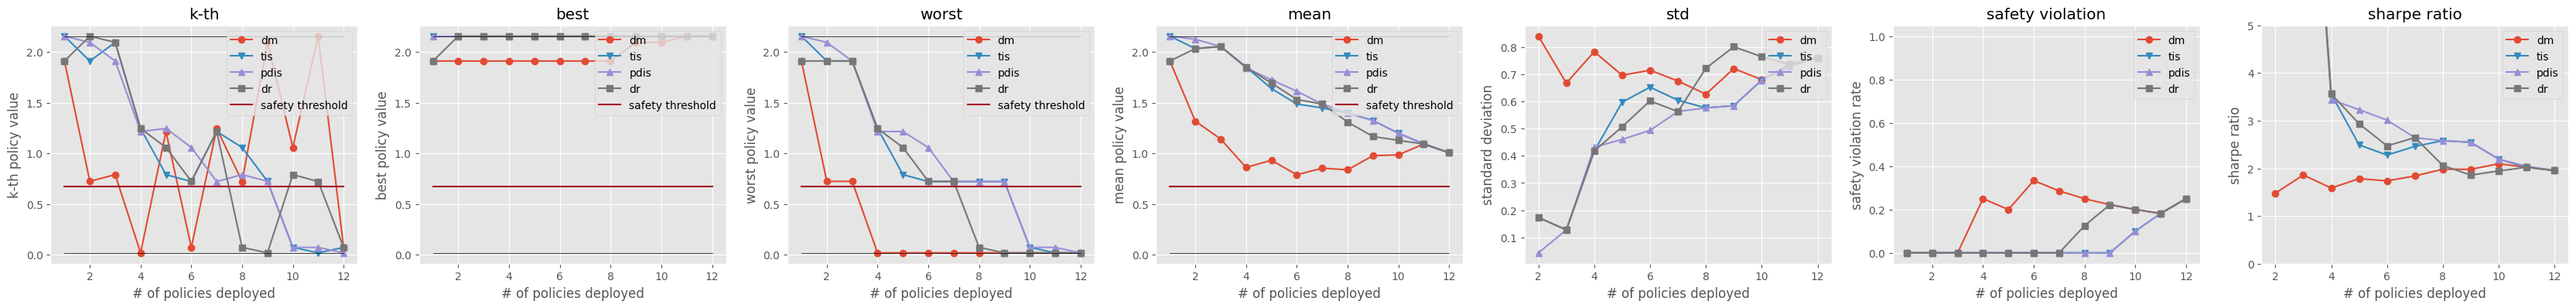

In [74]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

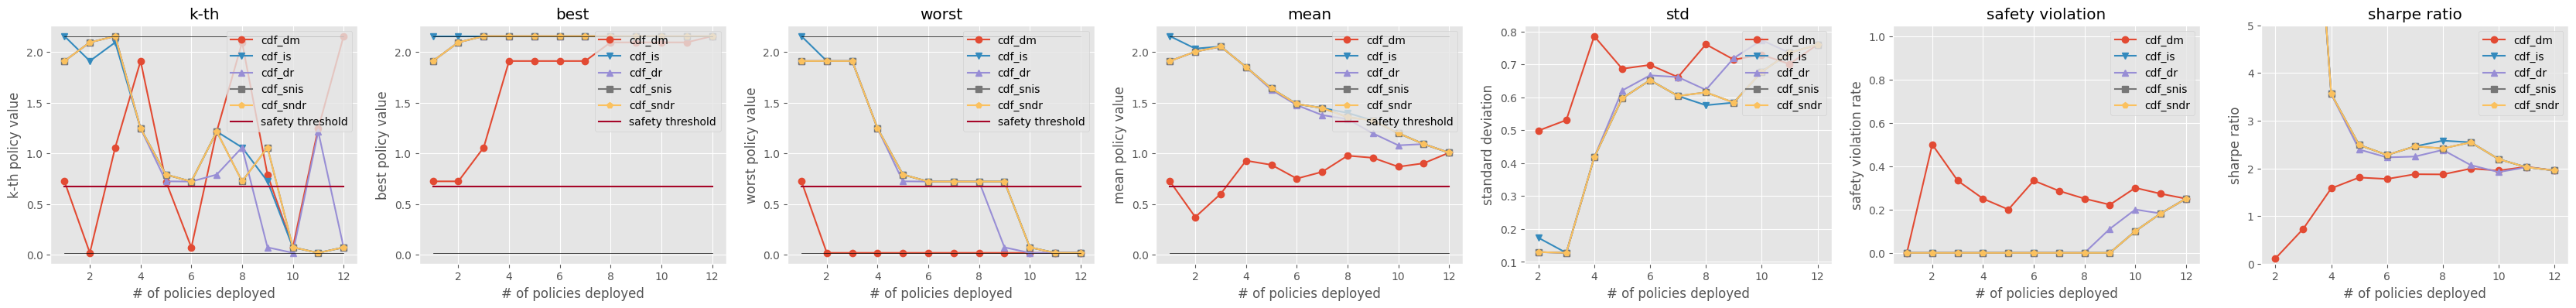

In [75]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

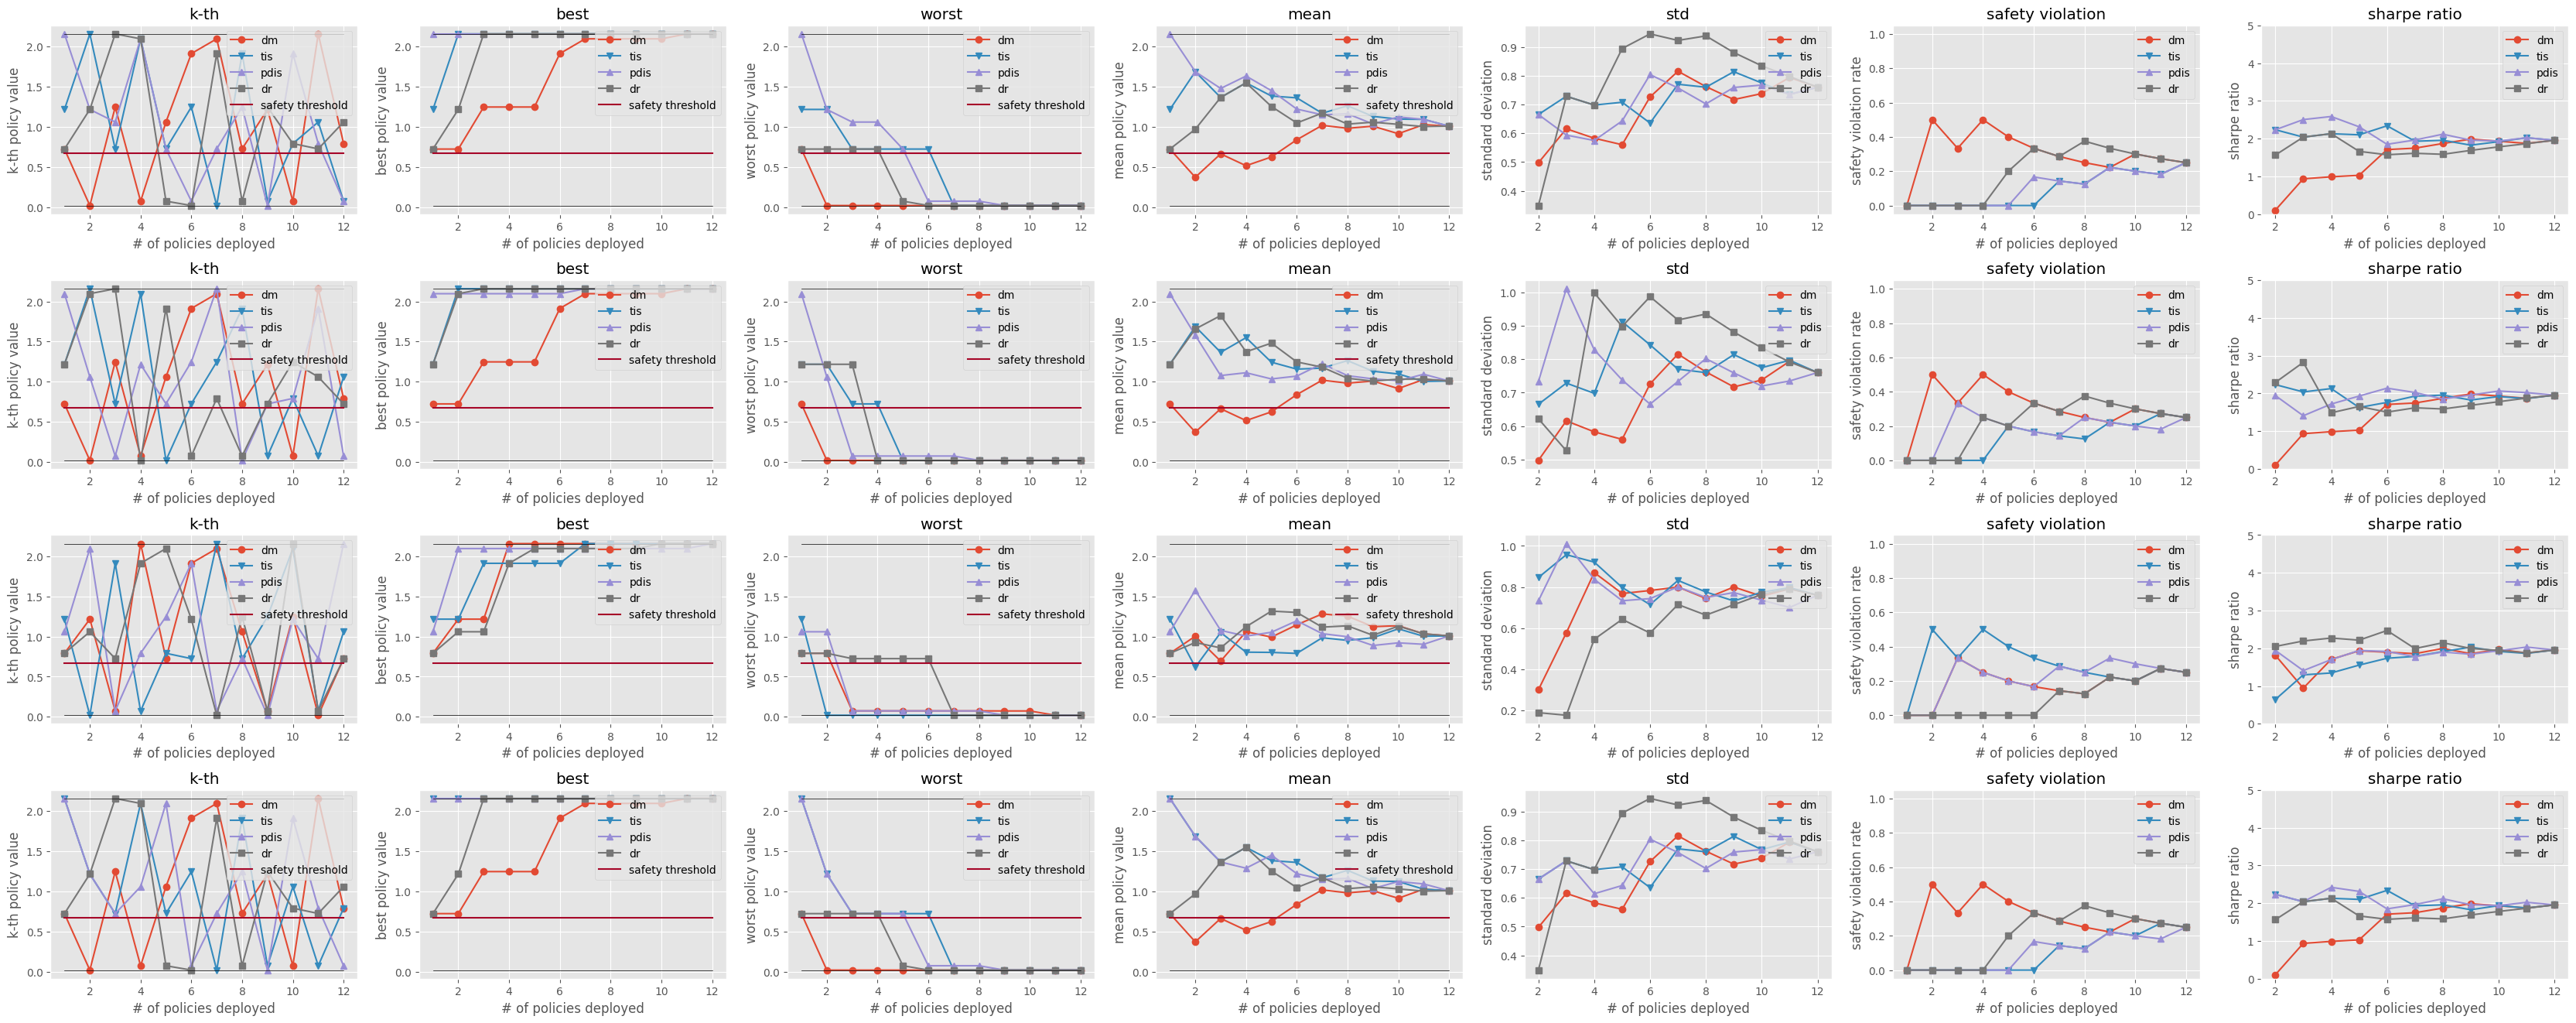

In [76]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=12345,
)

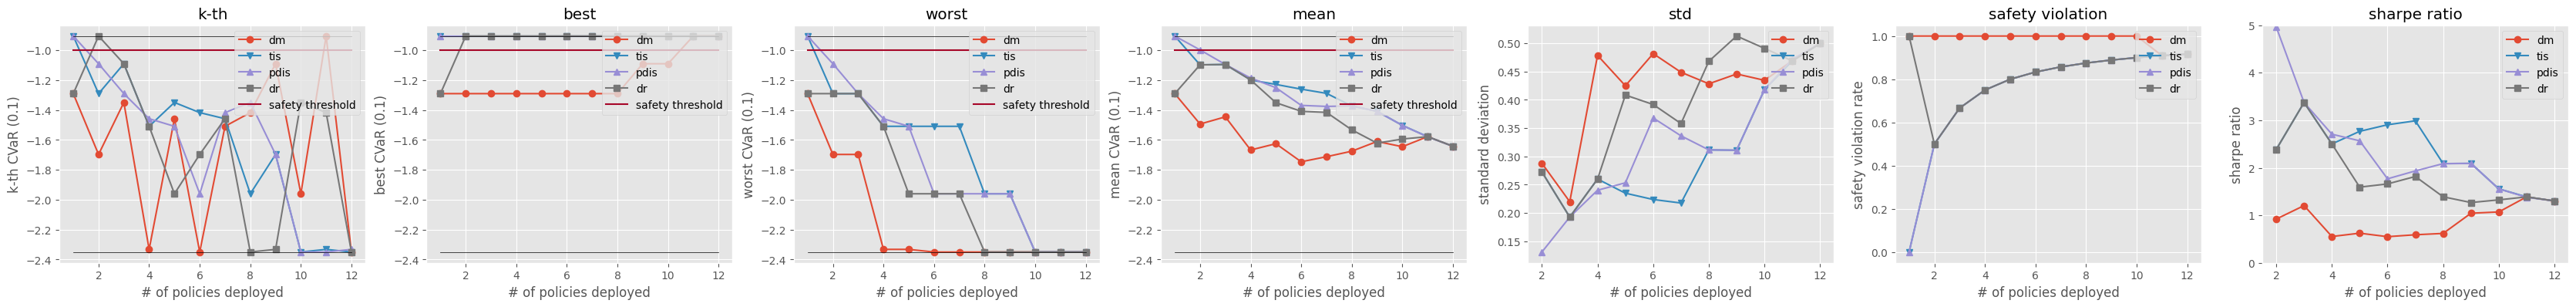

In [77]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=-1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

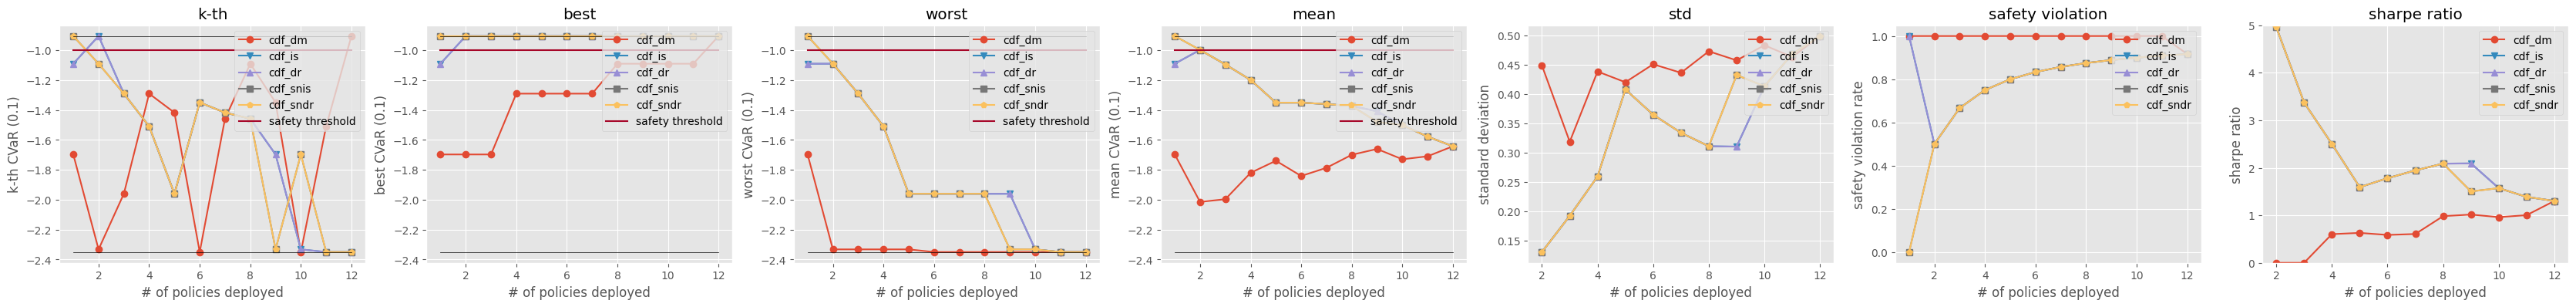

In [78]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=-1.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
)

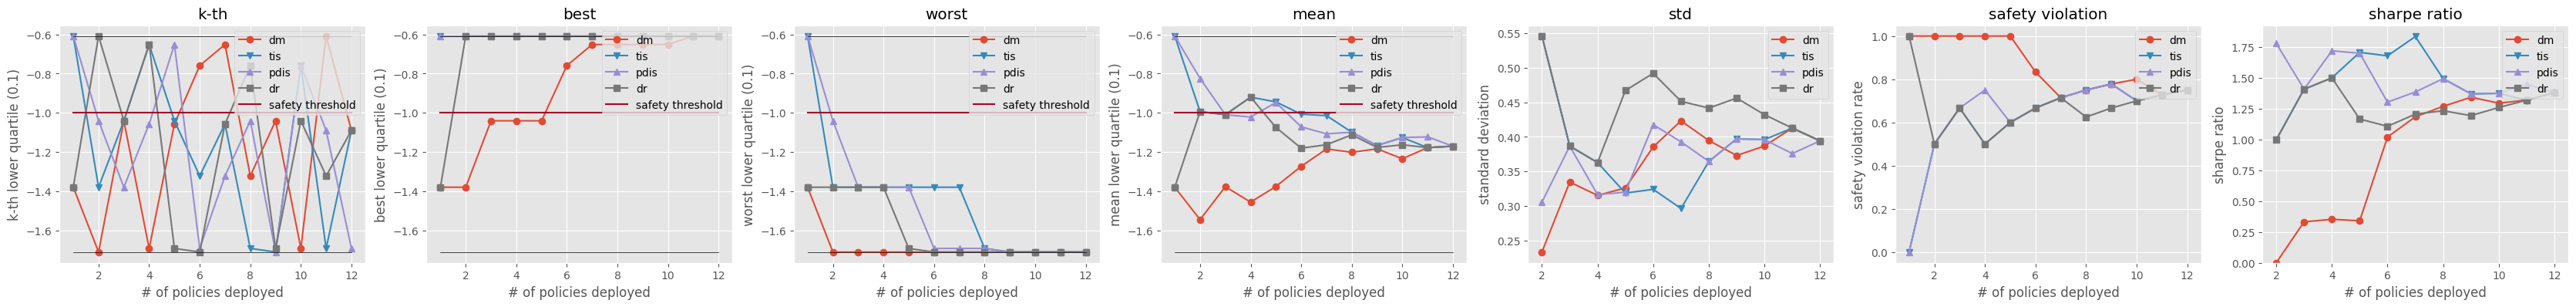

In [87]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=-1.0,
    legend=True,
)

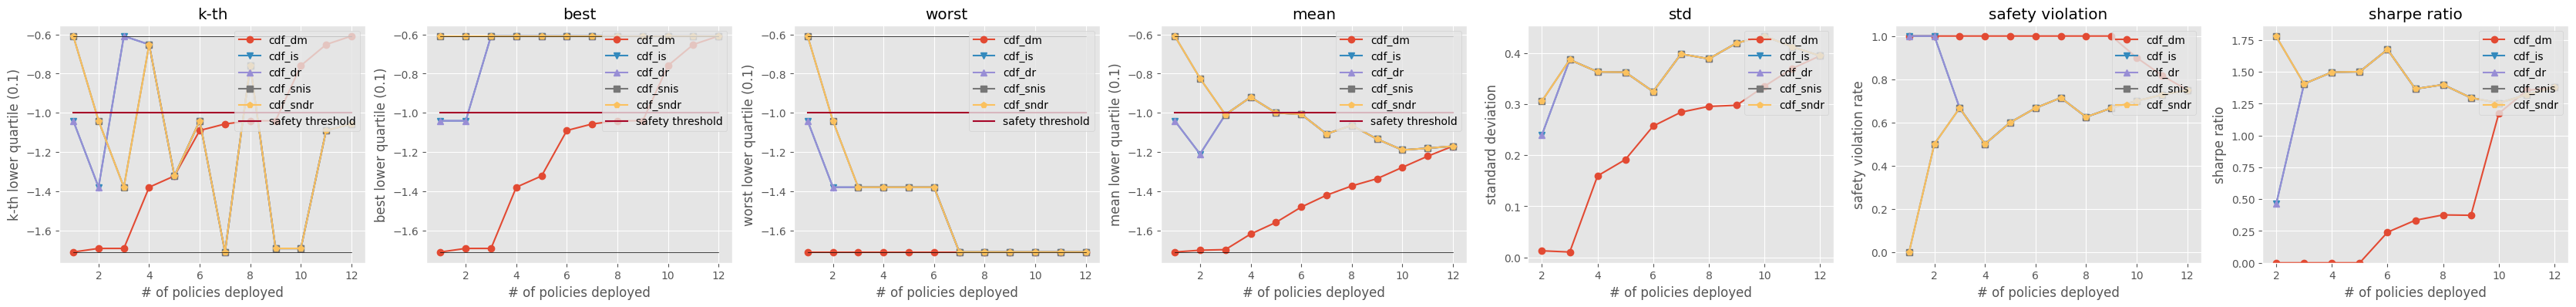

In [86]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=-1.0,
    legend=True,
)

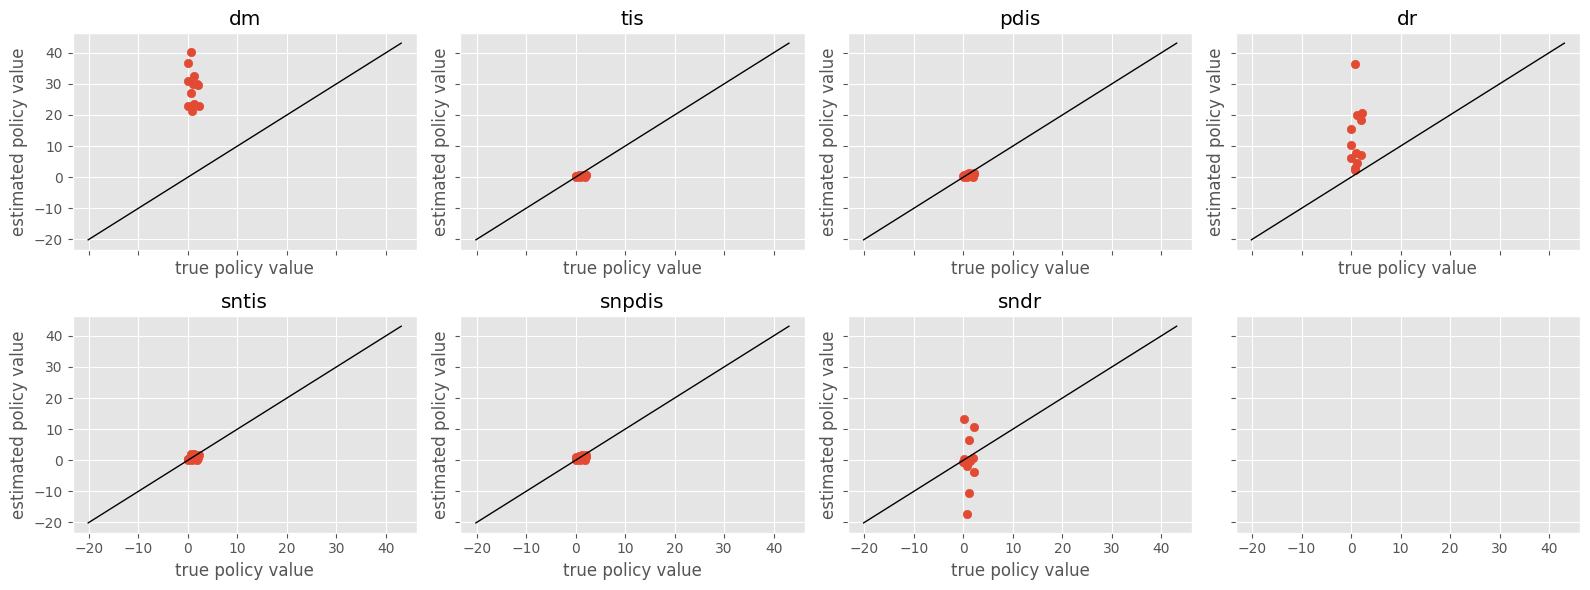

In [81]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

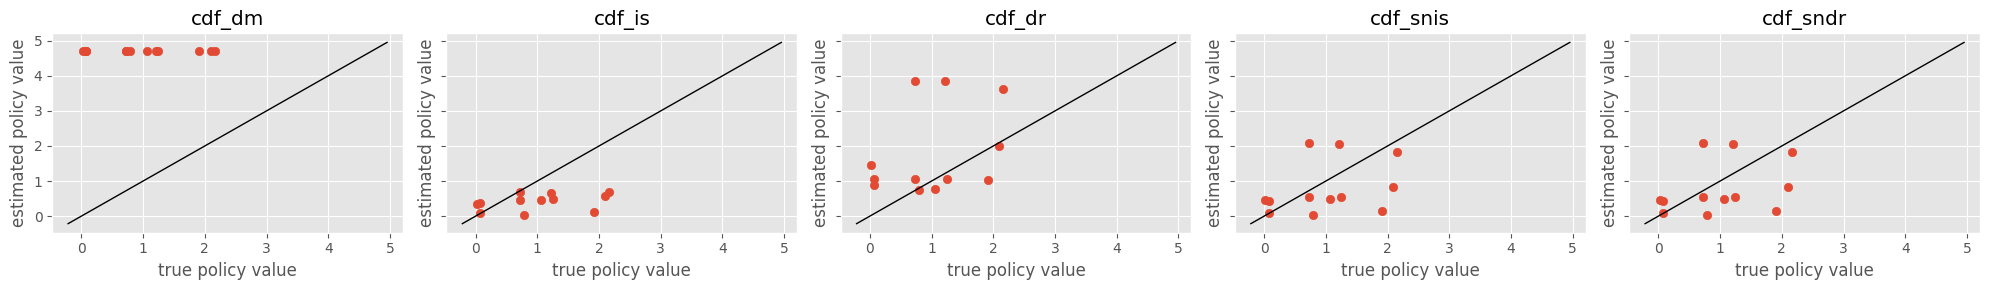

In [82]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

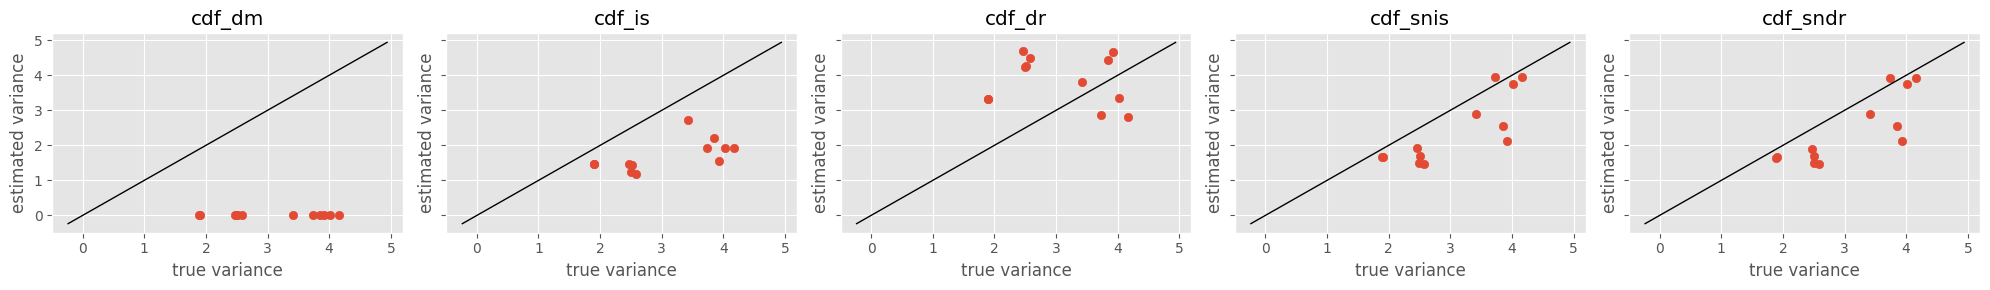

In [83]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

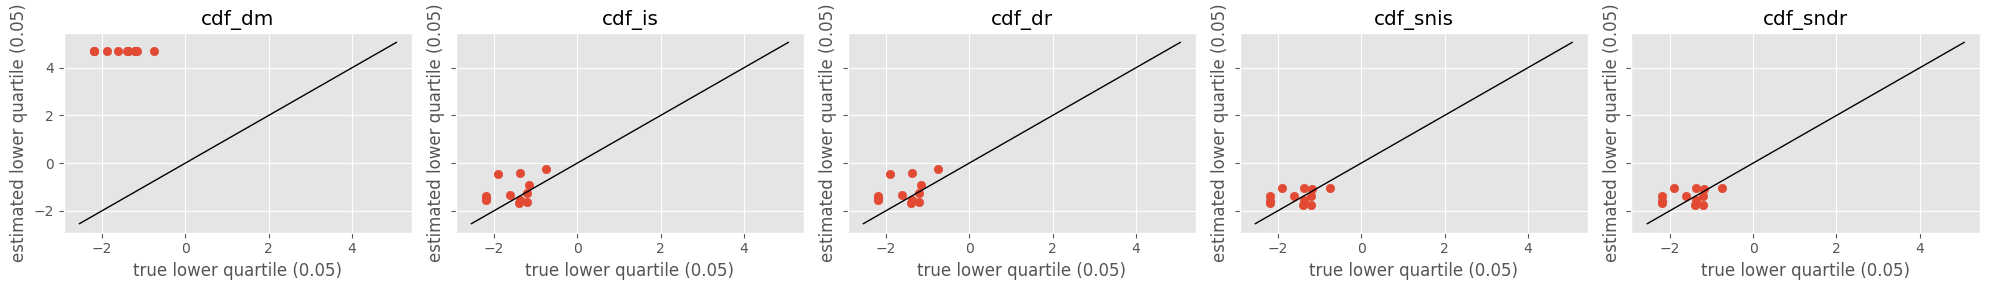

In [84]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

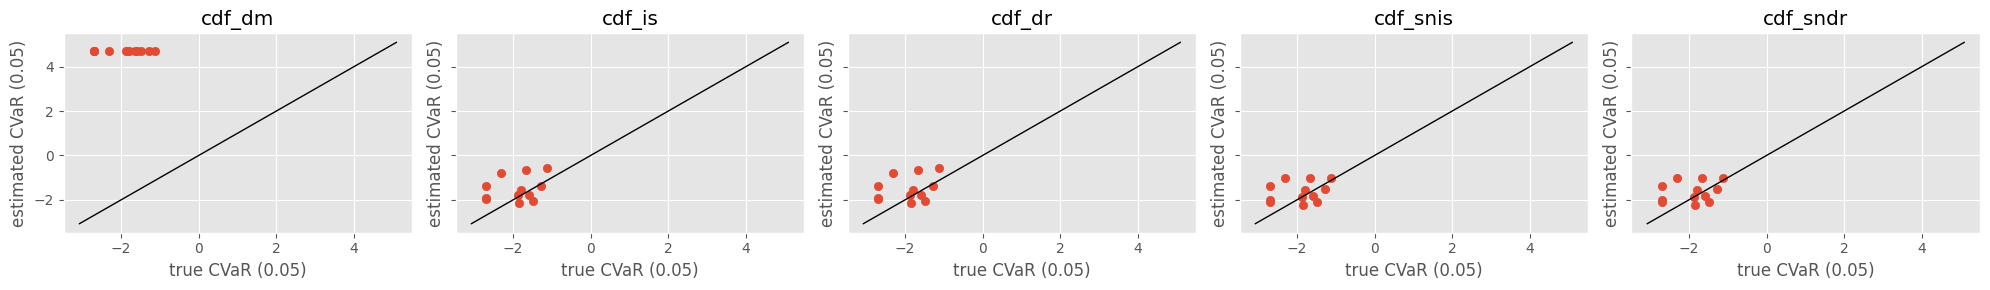

In [85]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

To see how to conduct OPE/OPS with multiple datasets, please refer to [examples/quickstart/rec/rec_synthetic_discrete_multiple_datasets.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_discrete_multiple_datasets.ipynb).

<!-- For the examples in the continuous action space, please refer to [examples/quickstart/rec/rec_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/scope_rl/blob/ope/examples/quickstart/rec/rec_synthetic_continuous_advanced.ipynb). -->

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.